In [1]:
from asyncio.windows_events import NULL
import os
from PIL.Image import ID
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
#import PlottingFunctions as pf
from mpl_toolkits.mplot3d import Axes3D
from tqdm.auto import tqdm
from time import perf_counter
# %matplotlib widget

plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (10,10)

# Function definition

In [2]:
import math
def calculate_descriptive_values(X):
    result = []
    for entry in X:
        length = len(entry)
        if length > 1:
            step = round(entry[1] - entry[0], 1)
        else:
            step = 0  # Default step if there's only one element
        result.append([length, step])
    return result

def calculate_std_pos(y, yerr):
    result = np.zeros_like(yerr)
    for i, yi in enumerate(y):
        result[i,0] = yi - yerr[i,0]
        result[i,1] = yi + yerr[i,1]
    return result

def llist_to_str(llist):
    str_ = []
    for list_ in llist:
        str_.append(str(list_))
    return np.array(str_)

def save_object(obj, fname='data.pickle'):
    '''
    saves a python object to a file using the built-in pickle library
    
    :param obj: The object to be saved
    :param fname: Name of the file in which to save the obj. Default is data.pickle
    '''
    try:
        with open(fname, "wb") as f:
            pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    except Exception as ex:
        print("Error during pickling object (Possibly unsupported):", ex)

def load_object(filename):
    '''
    load an object from a file using the built-in pickle library

    :param filename: Name of the file from which to load data
    '''
    try:
        with open(filename, "rb") as f:
            return pickle.load(f)
    except Exception as ex:
        print("Error during unpickling object (Possibly unsupported):", ex)

def pad_to_length(short_arr, target_length):
    """
    Given short_arr of shape (m, d), return a new array of shape (target_length, d)
    whose first (target_length - m) rows are NaN and whose last m rows are short_arr.
    """
    m, d = short_arr.shape
    if m == target_length:
        return short_arr.copy()
    elif m > target_length:
        raise ValueError(f"short_arr has more rows ({m}) than target_length ({target_length}).")
    # create a (target_length, d) array full of NaNs
    padded = np.full((target_length, d), np.nan, dtype=short_arr.dtype)
    # put the original data into the last m rows
    padded[-m :, :] = short_arr
    return padded

In [3]:
def plot_modular_activity(prj_op, pos, ac, gains, projection, neuron=0, save=False, bins=20, save_path='Results'):
    pos2d = np.einsum('mnx, tx->mtn', prj_op, pos)
    abc = np.array(['X', 'Y', 'Z'] if len(projection)==3 else ['X', 'Y']) 
    for i, p in enumerate(pos2d):
        print(f'Projection in {abc[projection[i]]}')
        heatmap, x_edge, y_edge = get_heatmap(p, ac[:,i], num_bins=bins, neuron=neuron)
        fig, ax, cbar = plot_heatmaps(heatmap, x_edge, y_edge, gains = gains, dimensions=abc[projection[i]])
        if save:
            plt.savefig(f'{save_path}\\ActivityPlane{abc[projection[i]]}neuron{neuron}.pdf', format='pdf')
        plt.show()
        
def get_heatmap(positions, activity, num_bins=50, neuron=0):
    """
    Generate a 3D heatmap of neural activity over XY space for different gain levels.

    Parameters
    ----------
    positions : array-like, shape = (ntime, 2)
        XY coordinates at each timepoint.
    activity : array-like, shape = (ntime, ngain, nneuron)
        Neural activity: time x gain levels x neurons.
    num_bins : int, optional (default=50)
        Number of bins along each spatial dimension.
    neuron : int, optional (default=42)
        Index of the neuron to plot.

    Returns
    -------
    heatmap : ndarray, shape = (ngain, num_bins, num_bins)
        Average activity of the specified neuron in each spatial bin for each gain.
        Bins with no samples are set to 0.
    x_edges : ndarray, shape = (num_bins + 1,)
        Bin edges along the X dimension.
    y_edges : ndarray, shape = (num_bins + 1,)
        Bin edges along the Y dimension.
    """
    positions = np.asarray(positions)
    activity = np.asarray(activity)

    # Validate dimensions
    ntime, dims = positions.shape
    t2, ngain, nneuron = activity.shape
    if t2 != ntime:
        raise ValueError(f"Time dimension mismatch: positions has {ntime}, activity has {t2}.")
    if neuron < 0 or neuron >= nneuron:
        raise ValueError(f"Neuron index out of bounds: should be in [0, {nneuron-1}].")

    # Define bin edges
    x_edges = np.linspace(positions[:, 0].min(), positions[:, 0].max(), num_bins + 1)
    y_edges = np.linspace(positions[:, 1].min(), positions[:, 1].max(), num_bins + 1)

    # Initialize accumulators
    sum_map = np.zeros((ngain, num_bins, num_bins), dtype=float)
    count_map = np.zeros((ngain, num_bins, num_bins), dtype=int)

    # Bin each sample
    for (x, y), act in zip(positions, activity):
        x_idx = np.clip(np.digitize(x, x_edges) - 1, 0, num_bins - 1)
        y_idx = np.clip(np.digitize(y, y_edges) - 1, 0, num_bins - 1)
        for g in range(ngain):
            sum_map[g, x_idx, y_idx] = max(act[g, neuron], sum_map[g, x_idx, y_idx])
            count_map[g, x_idx, y_idx] += 1

    # Compute average, set empty bins to 0
    heatmap = np.zeros_like(sum_map)
    nonzero = count_map > 0
    heatmap[nonzero] = sum_map[nonzero] #/ count_map[nonzero]
    # bins with no data remain 0

    return heatmap, x_edges, y_edges

def plot_heatmaps(heatmap, x_edges, y_edges, gains=None, cmap='viridis', dimensions=['X', 'Y']):
    """
    Plot one heatmap per gain level with a shared colorbar.

    Parameters
    ----------
    heatmap : ndarray, shape = (ngain, nbins, nbins)
        Heatmap data for each gain.
    x_edges : array-like, shape = (nbins + 1,)
        Bin edges along the X dimension.
    y_edges : array-like, shape = (nbins + 1,)
        Bin edges along the Y dimension.
    gains : list or array-like, optional
        Gain values corresponding to each heatmap slice. If None, gains are numbered 0..ngain-1.
    cmap : str, optional
        Matplotlib colormap name.

    Returns
    -------
    fig, axes, cbar : tuple
        Figure, axes array and the shared colorbar.
    """
    ngain, nbins, _ = heatmap.shape
    if gains is None:
        gains = np.arange(ngain)
    elif len(gains) != ngain:
        raise ValueError(f"Length of gains ({len(gains)}) must match heatmap dimension ({ngain}).")

    # Compute bin centers for plotting
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2

    fig, axes = plt.subplots(1, ngain, figsize=(5 * ngain, 5), constrained_layout=True)
    if ngain == 1:
        axes = [axes]

    vmin = np.min(heatmap)
    vmax = np.max(heatmap)

    for idx, ax in enumerate(axes):
        im = ax.imshow(
            heatmap[idx].T,
            origin='lower',
            extent=(x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]),
            aspect='auto',
            vmin=vmin,
            vmax=vmax,
            cmap=cmap
        )
        ax.set_title(f'Gain = {gains[idx]}')
        ax.set_xlabel(dimensions[0])
        ax.set_ylabel(dimensions[1])

    # Colorbar
    cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Normalised activity')

    return fig, axes, cbar

# Analysis of multitrial benchmarks

## Replication

In [4]:
settings = 5
s_name = 'Pure dissatisfaction CPU'

mse_rr_o = np.zeros(settings)
std_rr_o = np.zeros((settings, 2))
mse_rls_o = np.zeros(settings)
std_rls_o = np.zeros((settings, 2))
mse_rr_n = np.zeros(settings)
std_rr_n = np.zeros((settings, 2))
mse_rls_n = np.zeros(settings)
std_rls_n = np.zeros((settings, 2))
med_rr_o = np.zeros(settings)
iqr_rr_o = np.zeros((settings, 2))
med_rls_o = np.zeros(settings)
iqr_rls_o = np.zeros((settings, 2))
med_rr_n = np.zeros(settings)
iqr_rr_n = np.zeros((settings, 2))
med_rls_n = np.zeros(settings)
iqr_rls_n = np.zeros((settings, 2))
cov = np.zeros(settings)
cov_iqr = np.zeros((settings, 2))

for i in range(settings):
    name = f'{s_name} Setting {i}of{settings}'
    filename = f'Results\\ID {name}\\summary.pickle'
    data = load_object(filename)
        
    med_rr_o[i] = data['median mse_rr_overfit'] #data['median mse_rr overfit']
    iqr_rr_o[i] = data['iqr mse_rr_overfit']
    med_rls_o[i] = data['median mse_rls_overfit'] #data['median mse_rls overfit']
    iqr_rls_o[i] = data['iqr mse_rls_overfit']
    med_rr_n[i] = data['median mse_rr_heldout'] #data['median mse_rr non_overfit']
    iqr_rr_n[i] = data['iqr mse_rr_heldout']
    med_rls_n[i] = data['median mse_rls_heldout'] #data['median mse_rls non_overfit']
    iqr_rls_n[i] = data['iqr mse_rls_heldout']
    mse_rr_o[i] = data['mse mse_rr_overfit'] #data['median mse_rr overfit']
    std_rr_o[i] = data['std mse_rr_overfit']
    mse_rls_o[i] = data['mse mse_rls_overfit'] #data['median mse_rls overfit']
    std_rls_o[i] = data['std mse_rls_overfit']
    mse_rr_n[i] = data['mse mse_rr_heldout'] #data['median mse_rr non_overfit']
    std_rr_n[i] = data['std mse_rr_heldout']
    mse_rls_n[i] = data['mse mse_rls_heldout'] #data['median mse_rls non_overfit']
    std_rls_n[i] = data['std mse_rls_heldout']
    cov[i] = data['median volume']
    cov_iqr[i] = data['iqr volume']

    #print(f'{name} time = {time[i]}')
    #print(f' online trained  : {np.mean(mse_on[i]):.3} +- {std_on[i]:.3}')
    #print(f' online test     : {np.mean(mse_onSh[i]):.3} +- {std_onSh[i]:.3}')
    #print(f' offline trained : {mse_of[i]:.3} +- {std_of[i]:.3}')
    #print(f' offline test    : {mse_ofSh[i]:.3} +- {std_ofSh[i]:.3}')
setting = data['setting var']
print(data['setting mode'])
print(data['setting var'])

x = range(len(setting))
xticks = setting
std_rr_o = calculate_std_pos(mse_rr_o, std_rr_o)
std_rls_o = calculate_std_pos(mse_rls_o, std_rls_o)
std_rr_n = calculate_std_pos(mse_rr_n, std_rr_n)
std_rls_n = calculate_std_pos(mse_rls_n, std_rls_n)

replication
range(0, 5)


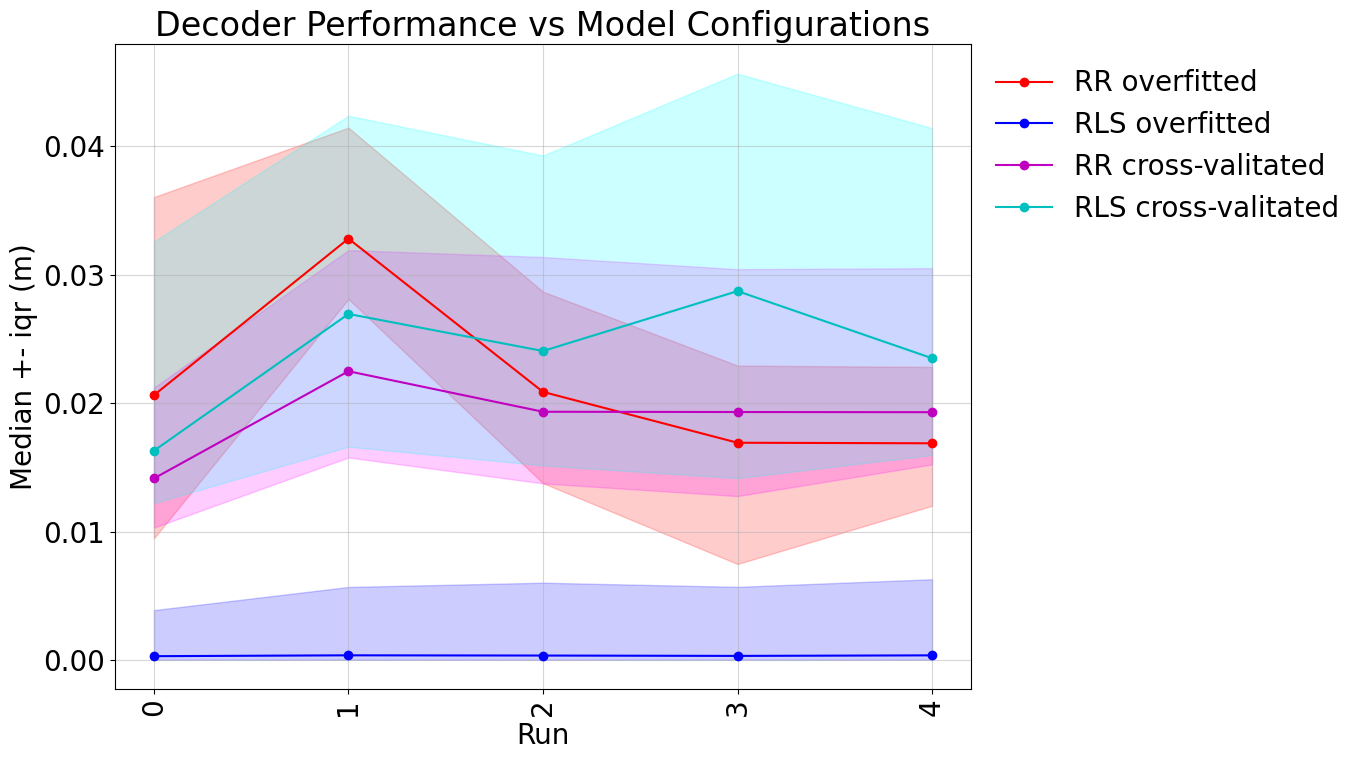

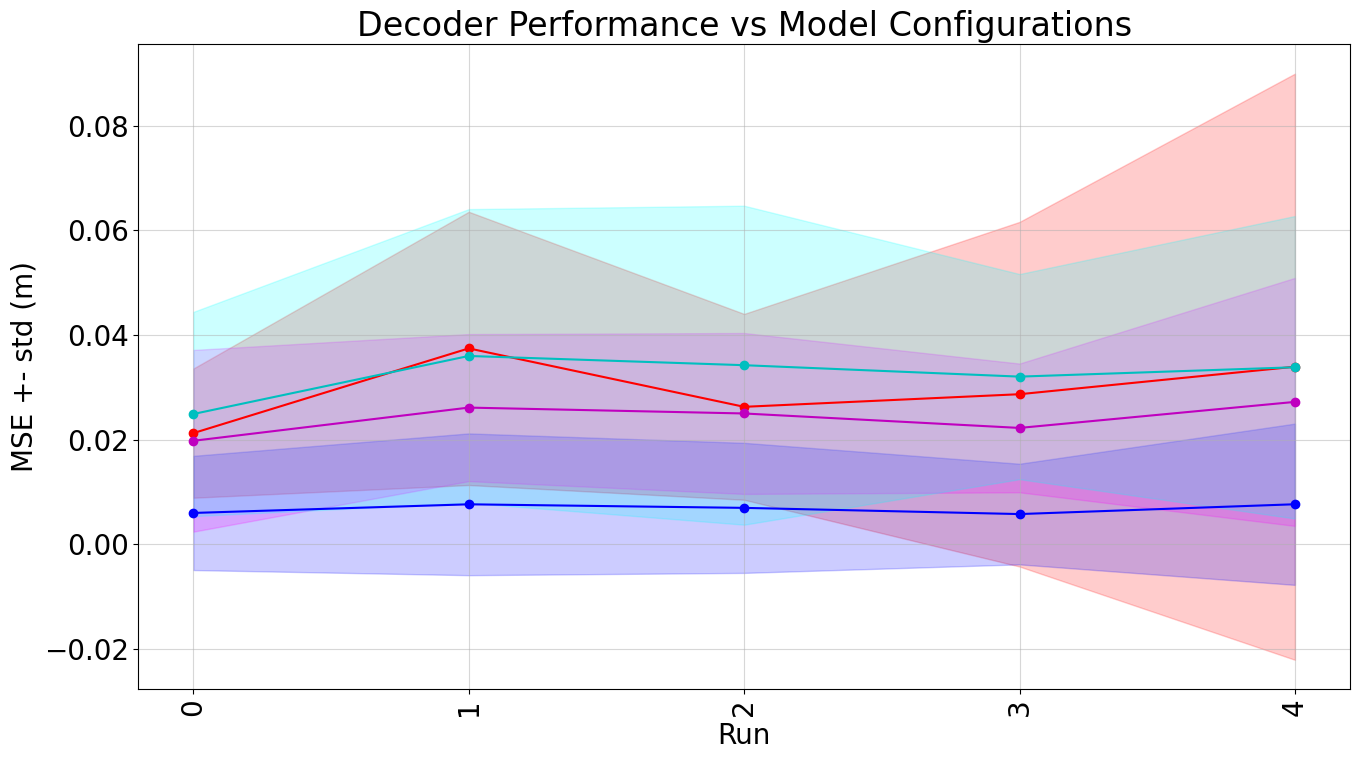

In [7]:
fig = plt.figure(figsize=(14,8))
plt.title("Decoder Performance vs Model Configurations")
plt.plot(x, med_rr_o, 'r-o', label='RR overfitted')
plt.fill_between(x, iqr_rr_o[:,0], iqr_rr_o[:,1], color='red', alpha=0.2)
plt.plot(x, med_rls_o, 'b-o', label='RLS overfitted')
plt.fill_between(x, iqr_rls_o[:,0], iqr_rls_o[:,1], color='blue', alpha=0.2)
plt.plot(x, med_rr_n, 'm-o', label='RR cross-valitated')
plt.fill_between(x, iqr_rr_n[:,0], iqr_rr_n[:,1], color='magenta', alpha=0.2)
plt.plot(x, med_rls_n, 'c-o', label='RLS cross-valitated')
plt.fill_between(x, iqr_rls_n[:,0], iqr_rls_n[:,1], color='cyan', alpha=0.2)
plt.grid(alpha=0.5)
plt.ylabel('Median +- iqr (m)')
plt.xlabel('Run')
plt.xticks(x, xticks, rotation='vertical')
plt.legend(bbox_to_anchor=(1,1), frameon=False)

plt.tight_layout()
#fig.savefig(f'Results\\ReviewFigures\\GainsMED.pdf', format='pdf', bbox_inches='tight')
fig.savefig(f'Results\\NewFigures\\ReplicateCPUMED.png', format='png', bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(14,8))
plt.title("Decoder Performance vs Model Configurations")
plt.plot(x, mse_rr_o, 'r-o', label='RR overfitted')
plt.fill_between(x, std_rr_o[:,0], std_rr_o[:,1], color='red', alpha=0.2)
plt.plot(x, mse_rls_o, 'b-o', label='RLS overfitted')
plt.fill_between(x, std_rls_o[:,0], std_rls_o[:,1], color='blue', alpha=0.2)
plt.plot(x, mse_rr_n, 'm-o', label='RR cross-valitated')
plt.fill_between(x, std_rr_n[:,0], std_rr_n[:,1], color='magenta', alpha=0.2)
plt.plot(x, mse_rls_n, 'c-o', label='RLS cross-valitated')
plt.fill_between(x, std_rls_n[:,0], std_rls_n[:,1], color='cyan', alpha=0.2)
plt.grid(alpha=0.5)
plt.ylabel('MSE +- std (m)')
plt.xlabel('Run')
plt.xticks(x, xticks, rotation='vertical')
#plt.legend(bbox_to_anchor=(1,1), frameon=False)

plt.tight_layout()
#fig.savefig(f'Results\\ReviewFigures\\GainsMSE.pdf', format='pdf', bbox_inches='tight')
fig.savefig(f'Results\\NewFigures\\ReplicateCPUMSE.png', format='png', bbox_inches='tight')
plt.show()

## Comparing Noise applycation

In [4]:
settings = 5
s_name = 'Review Noise Test with clipping'

mse_rr_o = np.zeros(settings)
iqr_rr_o = np.zeros((settings, 2))
mse_rls_o = np.zeros(settings)
iqr_rls_o = np.zeros((settings, 2))
mse_rr_n = np.zeros(settings)
iqr_rr_n = np.zeros((settings, 2))
mse_rls_n = np.zeros(settings)
iqr_rls_n = np.zeros((settings, 2))
cov = np.zeros(settings)
cov_iqr = np.zeros((settings, 2))

for i in range(settings):
    name = f'{s_name} Setting {i}of{settings}'
    filename = f'Results\\ID {name}\\summary.pickle'
    data = load_object(filename)
        
    mse_rr_o[i] = data['median mse_rr_overfit'] #data['median mse_rr overfit']
    iqr_rr_o[i] = data['iqr mse_rr_overfit']
    mse_rls_o[i] = data['median mse_rls_overfit'] #data['median mse_rls overfit']
    iqr_rls_o[i] = data['iqr mse_rls_overfit']
    mse_rr_n[i] = data['median mse_rr_heldout'] #data['median mse_rr non_overfit']
    iqr_rr_n[i] = data['iqr mse_rr_heldout']
    mse_rls_n[i] = data['median mse_rls_heldout'] #data['median mse_rls non_overfit']
    iqr_rls_n[i] = data['iqr mse_rls_heldout']
    cov[i] = data['median volume']
    cov_iqr[i] = data['iqr volume']

    #print(f'{name} time = {time[i]}')
    #print(f' online trained  : {np.mean(mse_on[i]):.3} +- {std_on[i]:.3}')
    #print(f' online test     : {np.mean(mse_onSh[i]):.3} +- {std_onSh[i]:.3}')
    #print(f' offline trained : {mse_of[i]:.3} +- {std_of[i]:.3}')
    #print(f' offline test    : {mse_ofSh[i]:.3} +- {std_ofSh[i]:.3}')
setting = data['setting var']
print(data['setting mode'])
print(data['setting var'])

noise variation
[0.05, 0.1, 0.2, 0.35, 0.5]


In [5]:
s_name = 'Review Noise Test'

mse_rr_o_1 = np.zeros(settings)
iqr_rr_o_1 = np.zeros((settings, 2))
mse_rls_o_1 = np.zeros(settings)
iqr_rls_o_1 = np.zeros((settings, 2))
mse_rr_n_1 = np.zeros(settings)
iqr_rr_n_1 = np.zeros((settings, 2))
mse_rls_n_1 = np.zeros(settings)
iqr_rls_n_1 = np.zeros((settings, 2))

for i in range(settings):
    name = f'{s_name} Setting {i}of{settings}'
    filename = f'Results\\ID {name}\\summary.pickle'
    data = load_object(filename)
        
    mse_rr_o_1[i] = data['median mse_rr_overfit']
    iqr_rr_o_1[i] = data['iqr mse_rr_overfit']
    mse_rls_o_1[i] = data['median mse_rls_overfit']
    iqr_rls_o_1[i] = data['iqr mse_rls_overfit']
    mse_rr_n_1[i] = data['median mse_rr_heldout']
    iqr_rr_n_1[i] = data['iqr mse_rr_heldout']
    mse_rls_n_1[i] = data['median mse_rls_heldout']
    iqr_rls_n_1[i] = data['iqr mse_rls_heldout']
setting = data['setting var']

In [6]:
mse_rls_o, mse_rr_o, mse_rls_n, mse_rr_n

(array([0.17485256, 0.61704057, 0.90832734, 0.9857434 , 1.04958618]),
 array([0.02364937, 0.13101007, 0.29058459, 0.43511555, 0.54832625]),
 array([0.64319235, 1.03609157, 1.0822432 , 1.12008429, 1.1332314 ]),
 array([0.62968653, 1.05752599, 1.03487694, 0.89458334, 0.80442011]))

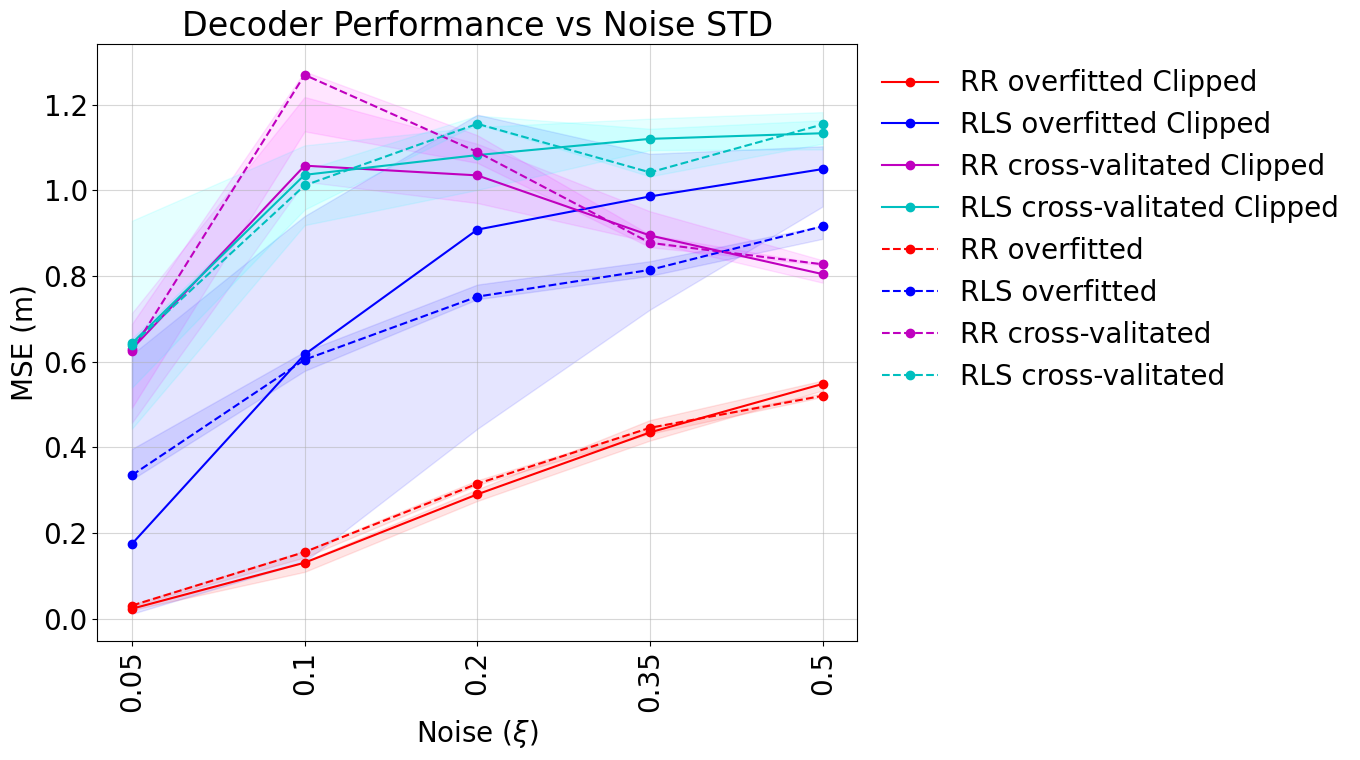

In [7]:
x = range(len(setting))
fig = plt.figure(figsize=(14,8))
plt.title("Decoder Performance vs Noise STD")

plt.plot(x, mse_rr_o, 'r-o', label='RR overfitted Clipped')
plt.fill_between(x, iqr_rr_o[:,0], iqr_rr_o[:,1], color='red', alpha=0.1)
plt.plot(x, mse_rls_o, 'b-o', label='RLS overfitted Clipped')
plt.fill_between(x, iqr_rls_o[:,0], iqr_rls_o[:,1], color='blue', alpha=0.1)
plt.plot(x, mse_rr_n, 'm-o', label='RR cross-valitated Clipped')
plt.fill_between(x, iqr_rr_n[:,0], iqr_rr_n[:,1], color='magenta', alpha=0.1)
plt.plot(x, mse_rls_n, 'c-o', label='RLS cross-valitated Clipped')
plt.fill_between(x, iqr_rls_n[:,0], iqr_rls_n[:,1], color='cyan', alpha=0.1)

plt.plot(x, mse_rr_o_1, 'r--o', label='RR overfitted')
plt.fill_between(x, iqr_rr_o_1[:,0], iqr_rr_o_1[:,1], color='red', alpha=0.1)
plt.plot(x, mse_rls_o_1, 'b--o', label='RLS overfitted')
plt.fill_between(x, iqr_rls_o_1[:,0], iqr_rls_o_1[:,1], color='blue', alpha=0.1)
plt.plot(x, mse_rr_n_1, 'm--o', label='RR cross-valitated')
plt.fill_between(x, iqr_rr_n_1[:,0], iqr_rr_n_1[:,1], color='magenta', alpha=0.1)
plt.plot(x, mse_rls_n_1, 'c--o', label='RLS cross-valitated')
plt.fill_between(x, iqr_rls_n_1[:,0], iqr_rls_n_1[:,1], color='cyan', alpha=0.1)

plt.grid(alpha=0.5)
plt.ylabel('MSE (m)')
plt.xlabel('Noise ($\\xi$)')
plt.xticks(x, setting, rotation='vertical')
plt.legend(bbox_to_anchor=(1,1), frameon=False)

plt.tight_layout()
#fig.savefig(f'Results\\PaperFigures\\PaperGains.pdf', format='pdf', bbox_inches='tight')
fig.savefig(f'Results\\ReviewFigures\\NoiseComparison.png', format='png', bbox_inches='tight')
plt.show()

## Noise

In [15]:
settings = 8
s_name = 'additive Noise Variation'#'additive Noise Variation'

mse_rr_o = np.zeros(settings)
std_rr_o = np.zeros((settings, 2))
mse_rls_o = np.zeros(settings)
std_rls_o = np.zeros((settings, 2))
mse_rr_n = np.zeros(settings)
std_rr_n = np.zeros((settings, 2))
mse_rls_n = np.zeros(settings)
std_rls_n = np.zeros((settings, 2))
med_rr_o = np.zeros(settings)
iqr_rr_o = np.zeros((settings, 2))
med_rls_o = np.zeros(settings)
iqr_rls_o = np.zeros((settings, 2))
med_rr_n = np.zeros(settings)
iqr_rr_n = np.zeros((settings, 2))
med_rls_n = np.zeros(settings)
iqr_rls_n = np.zeros((settings, 2))
cov = np.zeros(settings)
cov_iqr = np.zeros((settings, 2))

for i in range(settings):
    name = f'{s_name} Setting {i}of{settings}'
    filename = f'Results\\ID {name}\\summary.pickle'
    data = load_object(filename)
        
    med_rr_o[i] = data['median mse_rr_overfit']
    iqr_rr_o[i] = data['iqr mse_rr_overfit']
    med_rls_o[i] = data['median mse_rls_overfit']
    iqr_rls_o[i] = data['iqr mse_rls_overfit']
    med_rr_n[i] = data['median mse_rr_heldout']
    iqr_rr_n[i] = data['iqr mse_rr_heldout']
    med_rls_n[i] = data['median mse_rls_heldout']
    iqr_rls_n[i] = data['iqr mse_rls_heldout']
    # 
    mse_rr_o[i] = data['mse mse_rr_overfit']
    std_rr_o[i] = data['std mse_rr_overfit']
    mse_rls_o[i] = data['mse mse_rls_overfit']
    std_rls_o[i] = data['std mse_rls_overfit']
    mse_rr_n[i] = data['mse mse_rr_heldout']
    std_rr_n[i] = data['std mse_rr_heldout']
    mse_rls_n[i] = data['mse mse_rls_heldout']
    std_rls_n[i] = data['std mse_rls_heldout']
    cov[i] = data['median volume']
    cov_iqr[i] = data['iqr volume']

    #print(f'{name} time = {time[i]}')
    #print(f' online trained  : {np.mean(mse_on[i]):.3} +- {std_on[i]:.3}')
    #print(f' online test     : {np.mean(mse_onSh[i]):.3} +- {std_onSh[i]:.3}')
    #print(f' offline trained : {mse_of[i]:.3} +- {std_of[i]:.3}')
    #print(f' offline test    : {mse_ofSh[i]:.3} +- {std_ofSh[i]:.3}')
setting = data['setting var']
print(data['setting mode'])
print(data['setting var'])

std_rr_o = calculate_std_pos(mse_rr_o, std_rr_o)
std_rls_o = calculate_std_pos(mse_rls_o, std_rls_o)
std_rr_n = calculate_std_pos(mse_rr_n, std_rr_n)
std_rls_n = calculate_std_pos(mse_rls_n, std_rls_n)

noise variation
[0, 0.005, 0.01, 0.05, 0.1, 0.2, 0.35, 0.5]


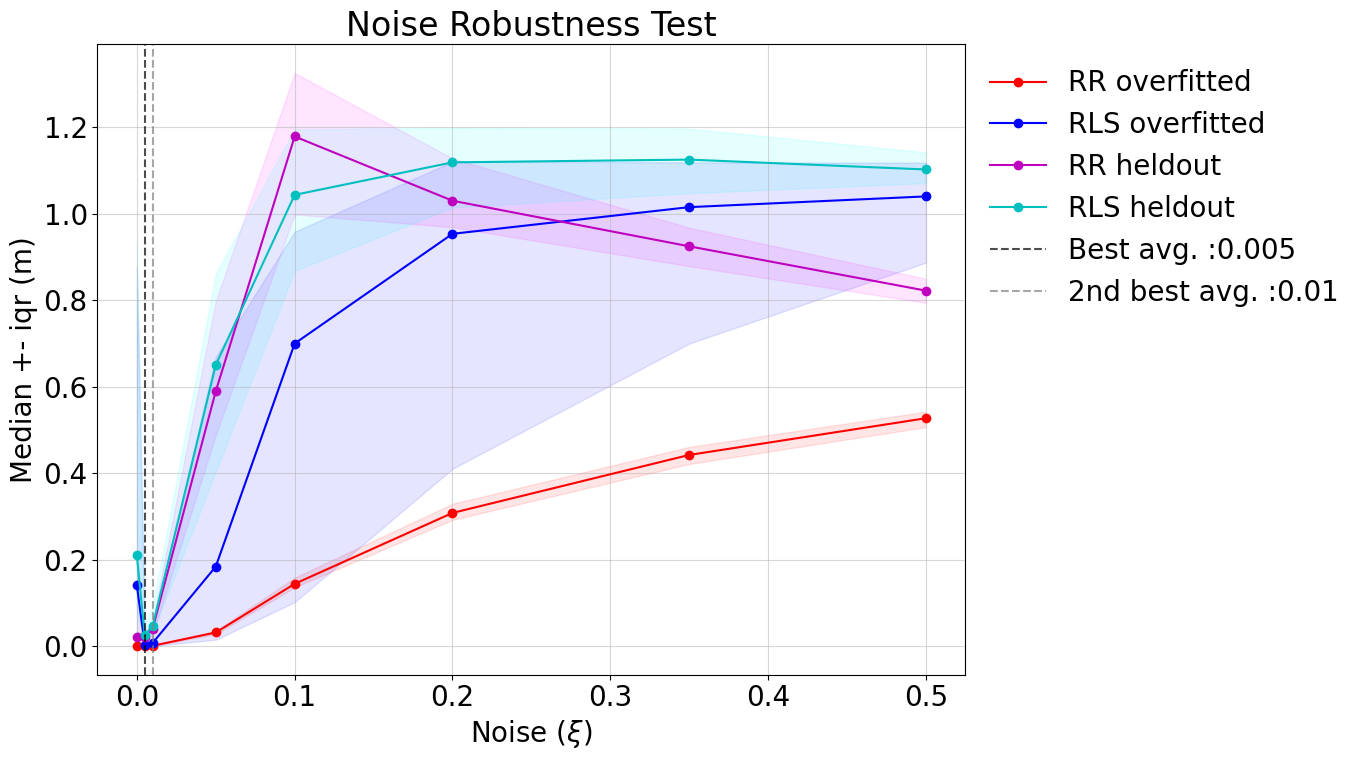

In [16]:
x = setting[:settings]

fig = plt.figure(figsize=(14,8))
plt.plot(x, med_rr_o, 'r-o', label='RR overfitted')
plt.fill_between(x, iqr_rr_o[:,0], iqr_rr_o[:,1], color='red', alpha=0.1)
plt.plot(x, med_rls_o, 'b-o', label='RLS overfitted')
plt.fill_between(x, iqr_rls_o[:,0], iqr_rls_o[:,1], color='blue', alpha=0.1)
plt.plot(x, med_rr_n, 'm-o', label='RR heldout')
plt.fill_between(x, iqr_rr_n[:,0], iqr_rr_n[:,1], color='magenta', alpha=0.1)
plt.plot(x, med_rls_n, 'c-o', label='RLS heldout')
plt.fill_between(x, iqr_rls_n[:,0], iqr_rls_n[:,1], color='cyan', alpha=0.1)

med_result = [med_rr_o, med_rls_o, med_rr_n, med_rls_n]
bestgain = np.argsort(np.sum(med_result, axis=0))
plt.axvline(x=x[bestgain[0]], color='black', linestyle='--', alpha=0.7, label=f'Best avg. :{x[bestgain[0]]}')
plt.axvline(x=x[bestgain[1]], color='grey', linestyle='--', alpha=0.7, label=f'2nd best avg. :{x[bestgain[1]]}')

plt.grid(alpha=0.5)
plt.ylabel('Median +- iqr (m)')
plt.xlabel('Noise ($\\xi$)')
plt.title('Noise Robustness Test')
plt.legend(frameon=False, bbox_to_anchor=(1.0,1.0))

plt.tight_layout()
#fig.savefig(f'Results\\New Figures\\PaperNoise.pdf', format='pdf', bbox_inches='tight')
fig.savefig(f'Results\\NewFigures\\NoiseMED.png', format='png', bbox_inches='tight')
plt.show()

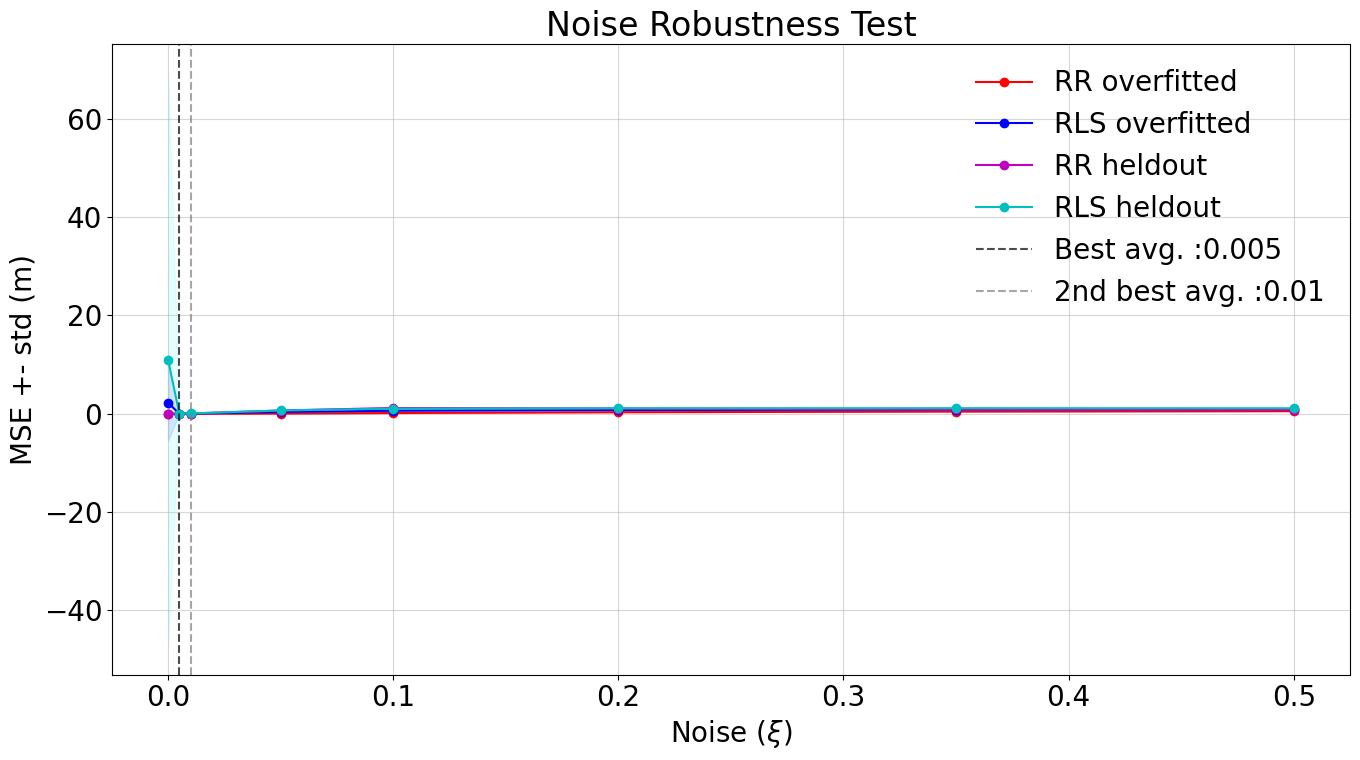

In [17]:
fig = plt.figure(figsize=(14,8))
plt.plot(x, mse_rr_o, 'r-o', label='RR overfitted')
plt.fill_between(x, std_rr_o[:,0], std_rr_o[:,1], color='red', alpha=0.1)
plt.plot(x, mse_rls_o, 'b-o', label='RLS overfitted')
plt.fill_between(x, std_rls_o[:,0], std_rls_o[:,1], color='blue', alpha=0.1)
plt.plot(x, mse_rr_n, 'm-o', label='RR heldout')
plt.fill_between(x, std_rr_n[:,0], std_rr_n[:,1], color='magenta', alpha=0.1)
plt.plot(x, mse_rls_n, 'c-o', label='RLS heldout')
plt.fill_between(x, std_rls_n[:,0], std_rls_n[:,1], color='cyan', alpha=0.1)

mse_result = [mse_rr_o, mse_rls_o, mse_rr_n, mse_rls_n]
bestgain = np.argsort(np.sum(mse_result, axis=0))
plt.axvline(x=x[bestgain[0]], color='black', linestyle='--', alpha=0.7, label=f'Best avg. :{x[bestgain[0]]}')
plt.axvline(x=x[bestgain[1]], color='grey', linestyle='--', alpha=0.7, label=f'2nd best avg. :{x[bestgain[1]]}')

plt.grid(alpha=0.5)
plt.ylabel('MSE +- std (m)')
plt.xlabel('Noise ($\\xi$)')
plt.title('Noise Robustness Test')
plt.legend(frameon=False, bbox_to_anchor=(1.0,1.0))

plt.tight_layout()
#fig.savefig(f'Results\\PaperNoise.pdf', format='pdf', bbox_inches='tight')
fig.savefig(f'Results\\NewFigures\\NoiseMSE.png', format='png', bbox_inches='tight')
plt.show()

## Gains

In [11]:
settings = 4
s_name = 'All Data Gain Variation'

mse_rr_o = np.zeros(settings)
std_rr_o = np.zeros((settings, 2))
mse_rls_o = np.zeros(settings)
std_rls_o = np.zeros((settings, 2))
mse_rr_n = np.zeros(settings)
std_rr_n = np.zeros((settings, 2))
mse_rls_n = np.zeros(settings)
std_rls_n = np.zeros((settings, 2))
med_rr_o = np.zeros(settings)
iqr_rr_o = np.zeros((settings, 2))
med_rls_o = np.zeros(settings)
iqr_rls_o = np.zeros((settings, 2))
med_rr_n = np.zeros(settings)
iqr_rr_n = np.zeros((settings, 2))
med_rls_n = np.zeros(settings)
iqr_rls_n = np.zeros((settings, 2))
cov = np.zeros(settings)
cov_iqr = np.zeros((settings, 2))

for i in range(settings):
    name = f'{s_name} Setting {i}of{settings}'
    filename = f'Results\\ID {name}\\summary.pickle'
    data = load_object(filename)
        
    med_rr_o[i] = data['median mse_rr_overfit'] #data['median mse_rr overfit']
    iqr_rr_o[i] = data['iqr mse_rr_overfit']
    med_rls_o[i] = data['median mse_rls_overfit'] #data['median mse_rls overfit']
    iqr_rls_o[i] = data['iqr mse_rls_overfit']
    med_rr_n[i] = data['median mse_rr_heldout'] #data['median mse_rr non_overfit']
    iqr_rr_n[i] = data['iqr mse_rr_heldout']
    med_rls_n[i] = data['median mse_rls_heldout'] #data['median mse_rls non_overfit']
    iqr_rls_n[i] = data['iqr mse_rls_heldout']
    mse_rr_o[i] = data['mse mse_rr_overfit'] #data['median mse_rr overfit']
    std_rr_o[i] = data['std mse_rr_overfit']
    mse_rls_o[i] = data['mse mse_rls_overfit'] #data['median mse_rls overfit']
    std_rls_o[i] = data['std mse_rls_overfit']
    mse_rr_n[i] = data['mse mse_rr_heldout'] #data['median mse_rr non_overfit']
    std_rr_n[i] = data['std mse_rr_heldout']
    mse_rls_n[i] = data['mse mse_rls_heldout'] #data['median mse_rls non_overfit']
    std_rls_n[i] = data['std mse_rls_heldout']
    cov[i] = data['median volume']
    cov_iqr[i] = data['iqr volume']

    #print(f'{name} time = {time[i]}')
    #print(f' online trained  : {np.mean(mse_on[i]):.3} +- {std_on[i]:.3}')
    #print(f' online test     : {np.mean(mse_onSh[i]):.3} +- {std_onSh[i]:.3}')
    #print(f' offline trained : {mse_of[i]:.3} +- {std_of[i]:.3}')
    #print(f' offline test    : {mse_ofSh[i]:.3} +- {std_ofSh[i]:.3}')
setting = data['setting var']
print(data['setting mode'])
print(data['setting var'])

std_rr_o = calculate_std_pos(mse_rr_o, std_rr_o)
std_rls_o = calculate_std_pos(mse_rls_o, std_rls_o)
std_rr_n = calculate_std_pos(mse_rr_n, std_rr_n)
std_rls_n = calculate_std_pos(mse_rls_n, std_rls_n)

gain variation
[[0.2, 0.3, 0.4, 0.5], [0.2, 0.4, 0.6, 0.8], [0.2, 0.5, 0.8, 1.1], [0.2, 0.6, 1.0, 1.4]]


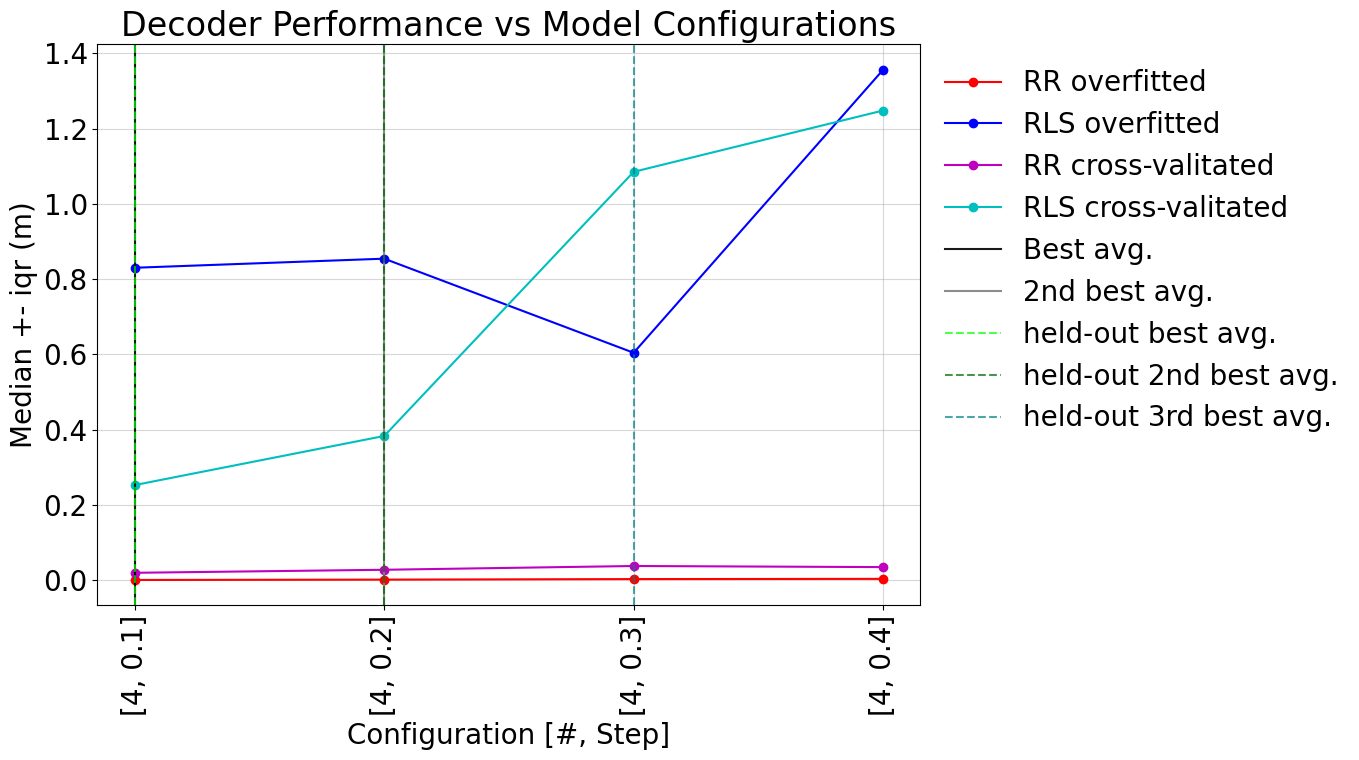

In [10]:
x = range(len(setting))
xticks = calculate_descriptive_values(setting)
med_result = [med_rr_o, med_rls_o, med_rr_n, med_rls_n]
bestgain = np.argsort(np.sum(med_result, axis=0))
heldoutbest = np.argsort(np.sum(med_result[2:], axis=0))

fig = plt.figure(figsize=(14,8))
plt.title("Decoder Performance vs Model Configurations")
plt.plot(x, med_rr_o, 'r-o', label='RR overfitted')
#plt.fill_between(x, iqr_rr_o[:,0], iqr_rr_o[:,1], color='red', alpha=0.1)
plt.plot(x, med_rls_o, 'b-o', label='RLS overfitted')
#plt.fill_between(x, iqr_rls_o[:,0], iqr_rls_o[:,1], color='blue', alpha=0.1)
plt.plot(x, med_rr_n, 'm-o', label='RR cross-valitated')
#plt.fill_between(x, iqr_rr_n[:,0], iqr_rr_n[:,1], color='magenta', alpha=0.1)
plt.plot(x, med_rls_n, 'c-o', label='RLS cross-valitated')
#plt.fill_between(x, iqr_rls_n[:,0], iqr_rls_n[:,1], color='cyan', alpha=0.1)
plt.grid(alpha=0.5)
plt.ylabel('Median +- iqr (m)')
plt.xlabel('Configuration [#, Step]')
plt.xticks(x, xticks, rotation='vertical')

# Plot performance
plt.axvline(x=x[bestgain[0]], color='black', linestyle='-', alpha=0.9,  label='Best avg.')
plt.axvline(x=x[bestgain[1]], color='grey', linestyle='-', alpha=0.9,  label='2nd best avg.')
plt.axvline(x=x[heldoutbest[0]], color='lime', linestyle='--', alpha=0.7,  label='held-out best avg.')
plt.axvline(x=x[heldoutbest[1]], color='darkgreen', linestyle='--', alpha=0.7,  label='held-out 2nd best avg.')
plt.axvline(x=x[heldoutbest[2]], color='teal', linestyle='--', alpha=0.7,  label='held-out 3rd best avg.')
plt.legend(bbox_to_anchor=(1,1), frameon=False)

plt.tight_layout()
#fig.savefig(f'Results\\ReviewFigures\\GainsMED.pdf', format='pdf', bbox_inches='tight')
fig.savefig(f'Results\\NewFigures\\GainsAllDataLMED.png', format='png', bbox_inches='tight')
plt.show()

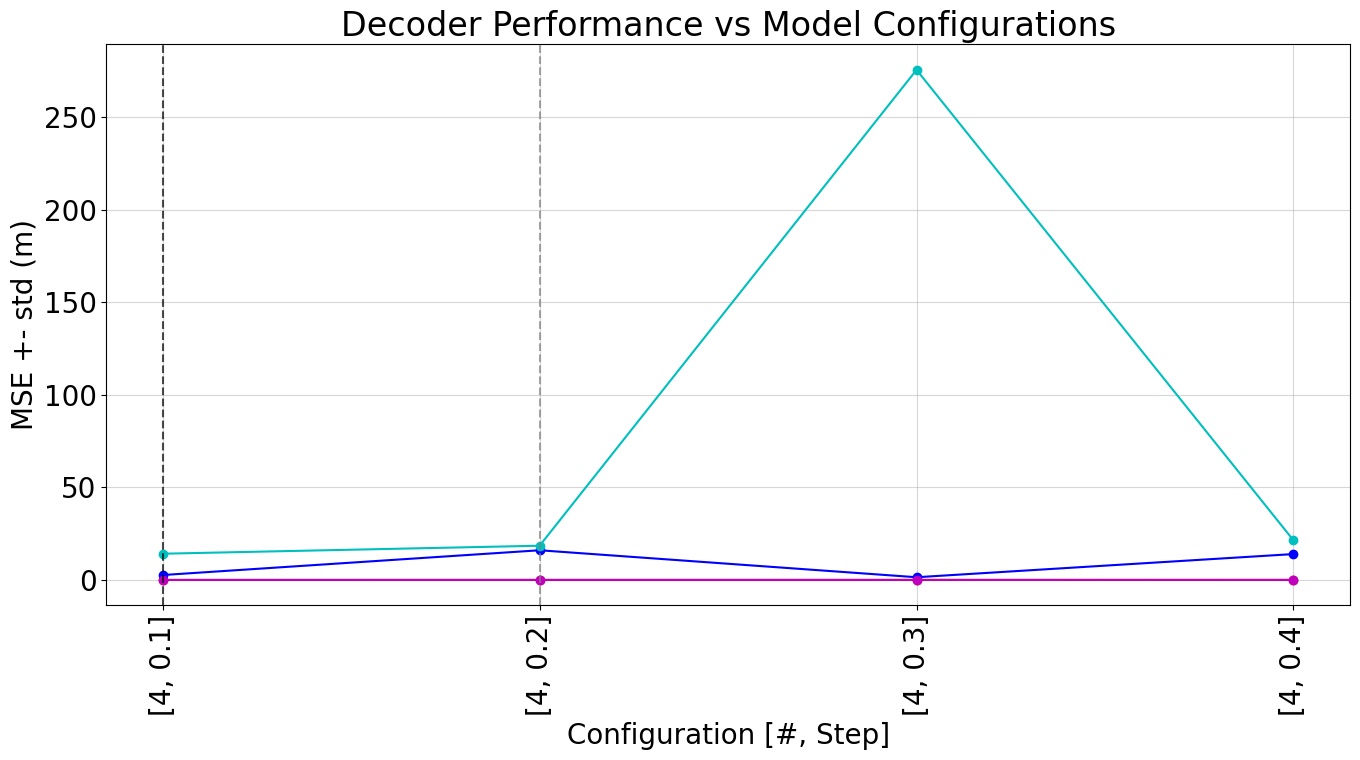

In [13]:
mse_result = [med_rr_o, med_rls_o, med_rr_n, med_rls_n]
bestgain = np.argsort(np.sum(mse_result, axis=0))

fig = plt.figure(figsize=(14,8))
plt.title("Decoder Performance vs Model Configurations")
plt.plot(x, mse_rr_o, 'r-o', label='RR overfitted')
#plt.fill_between(x, std_rr_o[:,0], std_rr_o[:,1], color='red', alpha=0.1)
plt.plot(x, mse_rls_o, 'b-o', label='RLS overfitted')
#plt.fill_between(x, std_rls_o[:,0], std_rls_o[:,1], color='blue', alpha=0.1)
plt.plot(x, mse_rr_n, 'm-o', label='RR cross-valitated')
#plt.fill_between(x, std_rr_n[:,0], std_rr_n[:,1], color='magenta', alpha=0.1)
plt.plot(x, mse_rls_n, 'c-o', label='RLS cross-valitated')
#plt.fill_between(x, std_rls_n[:,0], std_rls_n[:,1], color='cyan', alpha=0.1)

plt.axvline(x=x[bestgain[0]], color='black', linestyle='--', alpha=0.7, label='Best avg.')
plt.axvline(x=x[bestgain[1]], color='grey', linestyle='--', alpha=0.7, label='2nd best avg.')

plt.grid(alpha=0.5)
plt.ylabel('MSE +- std (m)')
plt.xlabel('Configuration [#, Step]')
plt.xticks(x, xticks, rotation='vertical')
#plt.legend(bbox_to_anchor=(1,1), frameon=False)

plt.tight_layout()
#fig.savefig(f'Results\\ReviewFigures\\GainsMSE.pdf', format='pdf', bbox_inches='tight')
fig.savefig(f'Results\\NewFigures\\GainsAllDataMSE.png', format='png', bbox_inches='tight')
plt.show()

## Time

In [24]:
settings = 6
s_name = 'additive Time Variation'

mse_rr_o = np.zeros(settings)
std_rr_o = np.zeros((settings, 2))
mse_rls_o = np.zeros(settings)
std_rls_o = np.zeros((settings, 2))
mse_rr_n = np.zeros(settings)
std_rr_n = np.zeros((settings, 2))
mse_rls_n = np.zeros(settings)
std_rls_n = np.zeros((settings, 2))
med_rr_o = np.zeros(settings)
iqr_rr_o = np.zeros((settings, 2))
med_rls_o = np.zeros(settings)
iqr_rls_o = np.zeros((settings, 2))
med_rr_n = np.zeros(settings)
iqr_rr_n = np.zeros((settings, 2))
med_rls_n = np.zeros(settings)
iqr_rls_n = np.zeros((settings, 2))
cov = np.zeros(settings)
cov_iqr = np.zeros((settings, 2))

for i in range(settings):
    name = f'{s_name} Setting {i}of{settings}'
    filename = f'Results\\ID {name}\\summary.pickle'
    data = load_object(filename)
        
    med_rr_o[i] = data['median mse_rr_overfit'] #data['median mse_rr overfit']
    iqr_rr_o[i] = data['iqr mse_rr_overfit']
    med_rls_o[i] = data['median mse_rls_overfit'] #data['median mse_rls overfit']
    iqr_rls_o[i] = data['iqr mse_rls_overfit']
    med_rr_n[i] = data['median mse_rr_heldout'] #data['median mse_rr non_overfit']
    iqr_rr_n[i] = data['iqr mse_rr_heldout']
    med_rls_n[i] = data['median mse_rls_heldout'] #data['median mse_rls non_overfit']
    iqr_rls_n[i] = data['iqr mse_rls_heldout']
    mse_rr_o[i] = data['mse mse_rr_overfit'] #data['median mse_rr overfit']
    std_rr_o[i] = data['std mse_rr_overfit']
    mse_rls_o[i] = data['mse mse_rls_overfit'] #data['median mse_rls overfit']
    std_rls_o[i] = data['std mse_rls_overfit']
    mse_rr_n[i] = data['mse mse_rr_heldout'] #data['median mse_rr non_overfit']
    std_rr_n[i] = data['std mse_rr_heldout']
    mse_rls_n[i] = data['mse mse_rls_heldout'] #data['median mse_rls non_overfit']
    std_rls_n[i] = data['std mse_rls_heldout']
    cov[i] = data['median volume']
    cov_iqr[i] = data['iqr volume']

    #print(f'{name} time = {time[i]}')
    #print(f' online trained  : {np.mean(mse_on[i]):.3} +- {std_on[i]:.3}')
    #print(f' online test     : {np.mean(mse_onSh[i]):.3} +- {std_onSh[i]:.3}')
    #print(f' offline trained : {mse_of[i]:.3} +- {std_of[i]:.3}')
    #print(f' offline test    : {mse_ofSh[i]:.3} +- {std_ofSh[i]:.3}')
setting = data['setting var']
print(data['setting mode'])
print(data['setting var'])

std_rr_o = calculate_std_pos(mse_rr_o, std_rr_o)
std_rls_o = calculate_std_pos(mse_rls_o, std_rls_o)
std_rr_n = calculate_std_pos(mse_rr_n, std_rr_n)
std_rls_n = calculate_std_pos(mse_rls_n, std_rls_n)

time variation
[5, 10, 15, 20, 25, 30]


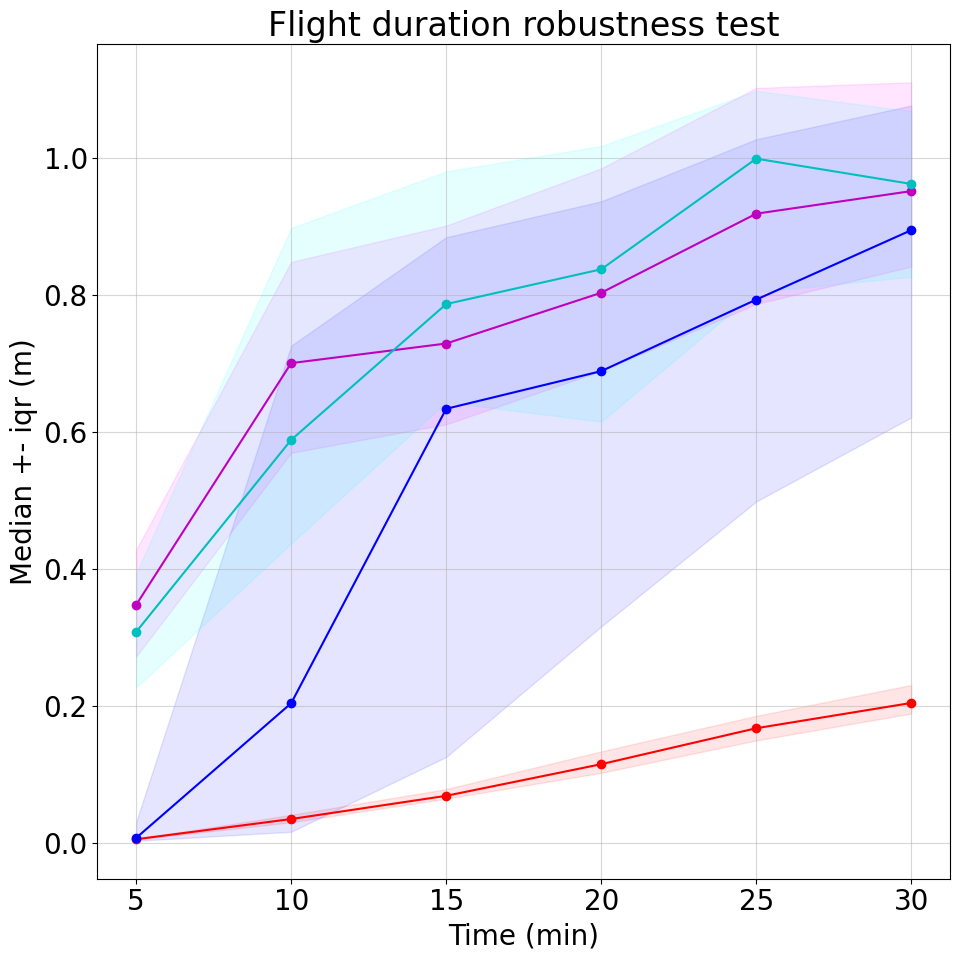

In [25]:
fig = plt.figure()
plt.title("Flight duration robustness test")
plt.plot(setting, med_rr_o, 'r-o', label='RR overfitted')
plt.fill_between(setting, iqr_rr_o[:,0], iqr_rr_o[:,1], color='red', alpha=0.1)
plt.plot(setting, med_rls_o, 'b-o', label='RLS overfitted')
plt.fill_between(setting, iqr_rls_o[:,0], iqr_rls_o[:,1], color='blue', alpha=0.1)
plt.plot(setting, med_rr_n, 'm-o', label='RR cross-valitated')
plt.fill_between(setting, iqr_rr_n[:,0], iqr_rr_n[:,1], color='magenta', alpha=0.1)
plt.plot(setting, med_rls_n, 'c-o', label='RLS cross-valitated')
plt.fill_between(setting, iqr_rls_n[:,0], iqr_rls_n[:,1], color='cyan', alpha=0.1)
plt.grid(alpha=0.5)
plt.ylabel('Median +- iqr (m)')
plt.xlabel('Time (min)')
#plt.legend(frameon=False)

plt.tight_layout()
#fig.savefig(f'Results\\Time.pdf', format='pdf', bbox_inches='tight')
fig.savefig(f'Results\\NewFigures\\Time.png', format='png', bbox_inches='tight')
plt.show()

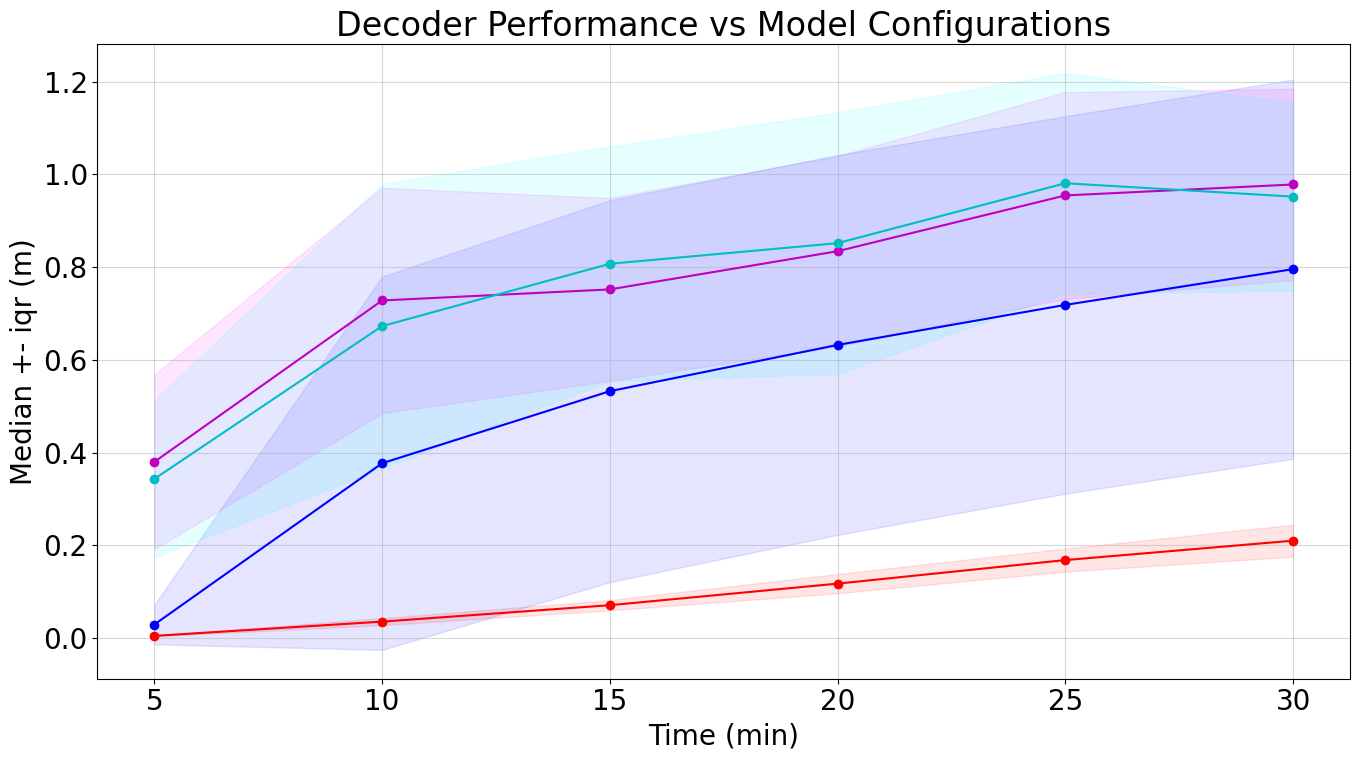

In [26]:
x = setting

fig = plt.figure(figsize=(14,8))
plt.title("Decoder Performance vs Model Configurations")
plt.plot(x, mse_rr_o, 'r-o', label='RR overfitted')
plt.fill_between(x, std_rr_o[:,0], std_rr_o[:,1], color='red', alpha=0.1)
plt.plot(x, mse_rls_o, 'b-o', label='RLS overfitted')
plt.fill_between(x, std_rls_o[:,0], std_rls_o[:,1], color='blue', alpha=0.1)
plt.plot(x, mse_rr_n, 'm-o', label='RR held-out')
plt.fill_between(x, std_rr_n[:,0], std_rr_n[:,1], color='magenta', alpha=0.1)
plt.plot(x, mse_rls_n, 'c-o', label='RLS held-out')
plt.fill_between(x, std_rls_n[:,0], std_rls_n[:,1], color='cyan', alpha=0.1)
plt.grid(alpha=0.5)
plt.ylabel('Median +- iqr (m)')
plt.xlabel('Time (min)')
#plt.legend(frameon=False)

plt.tight_layout()
#fig.savefig(f'Results\\Time.pdf', format='pdf', bbox_inches='tight')
fig.savefig(f'Results\\NewFigures\\TimeMSE.png', format='png', bbox_inches='tight')
plt.show()

### Coverage

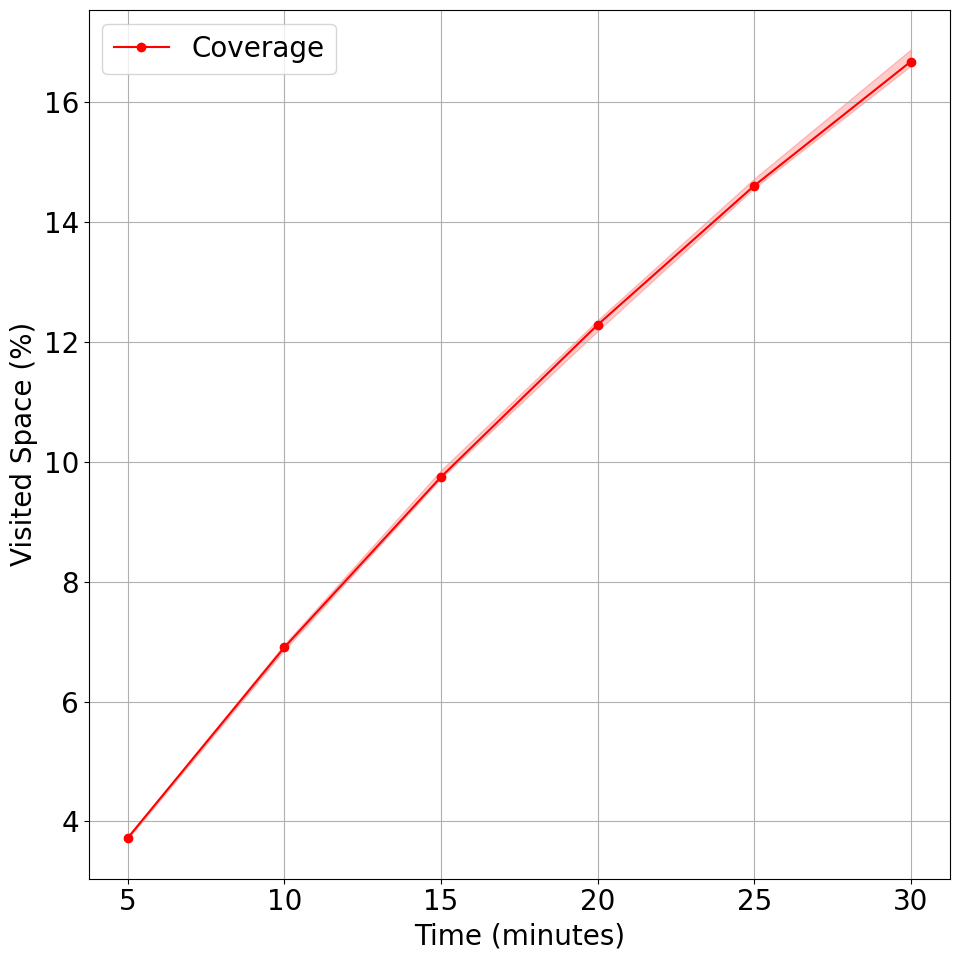

In [27]:
plt.plot(setting, cov,'r-o', label='Coverage')
plt.fill_between(setting, cov_iqr[:,0], cov_iqr[:,1], color='red', alpha=0.2)
#plt.ylim((0, 0.05))
plt.grid()
plt.legend()
plt.ylabel('Visited Space (%)')
plt.xlabel('Time (minutes)')
plt.tight_layout()
plt.savefig(f'Results\\NewFigures\\Coverage 3D.png', format='png')
plt.show()

### New Coverage

In [7]:
ARENA_BOUNDARIES = np.array([[-1, 1],  # x boundaries
                             [-1, 1],  # y boundaries
                             [-1, 1]]) # z boundaries

def visited_volume_percentages(trajectory, bounds, voxel_size=0.05, t=-1):
    """
    Compute the covered‐volume percentages for a 3D trajectory in a box.
    
    Parameters
    ----------
    trajectory : ndarray, shape (T, 3)
        Sequence of (x,y,z) points.
    bounds : tuple of floats
        (xmin, xmax, ymin, ymax, zmin, zmax).
    voxel_size : float
        Edge length of each cubic voxel in m.
    t : int
        Time‐index (0-based) up to which to report the partial coverage.
    
    Returns
    -------
    pct_up_to_t : float
        Percentage of box‐volume visited at least once in timesteps [0..t].
    pct_total : float
        Percentage of box‐volume visited at least once in the entire trajectory.
    """
    xmin, xmax, ymin, ymax, zmin, zmax = bounds
    
    # number of voxels along each axis
    nx = int(np.floor((xmax - xmin) / voxel_size)) + 1
    ny = int(np.floor((ymax - ymin) / voxel_size)) + 1
    nz = int(np.floor((zmax - zmin) / voxel_size)) + 1
    total_voxels = nx * ny * nz

    # map coords → integer voxel indices and clamp in [0, n-1]
    # shape (T,3) → (T,) linear indices
    scaled = (trajectory - np.array([xmin, ymin, zmin])) / voxel_size
    ijk = np.floor(scaled).astype(int)
    # clamp out-of-bounds points
    ijk[:,0] = np.clip(ijk[:,0], 0, nx-1)
    ijk[:,1] = np.clip(ijk[:,1], 0, ny-1)
    ijk[:,2] = np.clip(ijk[:,2], 0, nz-1)
    lin_idx = ijk[:,0] * (ny*nz) + ijk[:,1] * nz + ijk[:,2]

    # unique counts via np.unique
    unique_all = np.unique(lin_idx)
    unique_t   = np.unique(lin_idx[:t])

    pct_up_to_t = unique_t.size   / total_voxels * 100.0
    pct_total   = unique_all.size / total_voxels * 100.0 

    if (t != -1):
        return pct_up_to_t, pct_total
    return pct_total

In [110]:
### HERE RAIMON ! ###

filename = f'Results\\ID {name}\\data_trial0.pickle'
data = load_object(filename)
pos_r = np.array(data['position'])

visited_volume_percentages(pos_r, ARENA_BOUNDARIES.flatten(), voxel_size=0.05, t=-1)
# use the above function to calculate the volume coverage of a trajectory. The parameter t defines until which timestep the ratio should be calculated
# The voxel_size is the size in meters of the sides of the cube used for partitioning of the volume (0.05 means 40 bins)

20.343581782040307

## Computational Time

In [72]:
settings = 6

times = np.zeros(settings)
std = np.zeros((settings,2))
minutes = np.zeros(settings)

for i in range(settings):
    name = f'additive Time Variation Setting {i}of{settings}'
    filename = f'Results\\ID {name}\\summary.pickle'
    data = load_object(filename)
    minutes = data['setting var']
    
    time_mse = data['mse time taken']
    time_std = data['std time taken']
    
    times[i] = time_mse
    std[i] = time_std

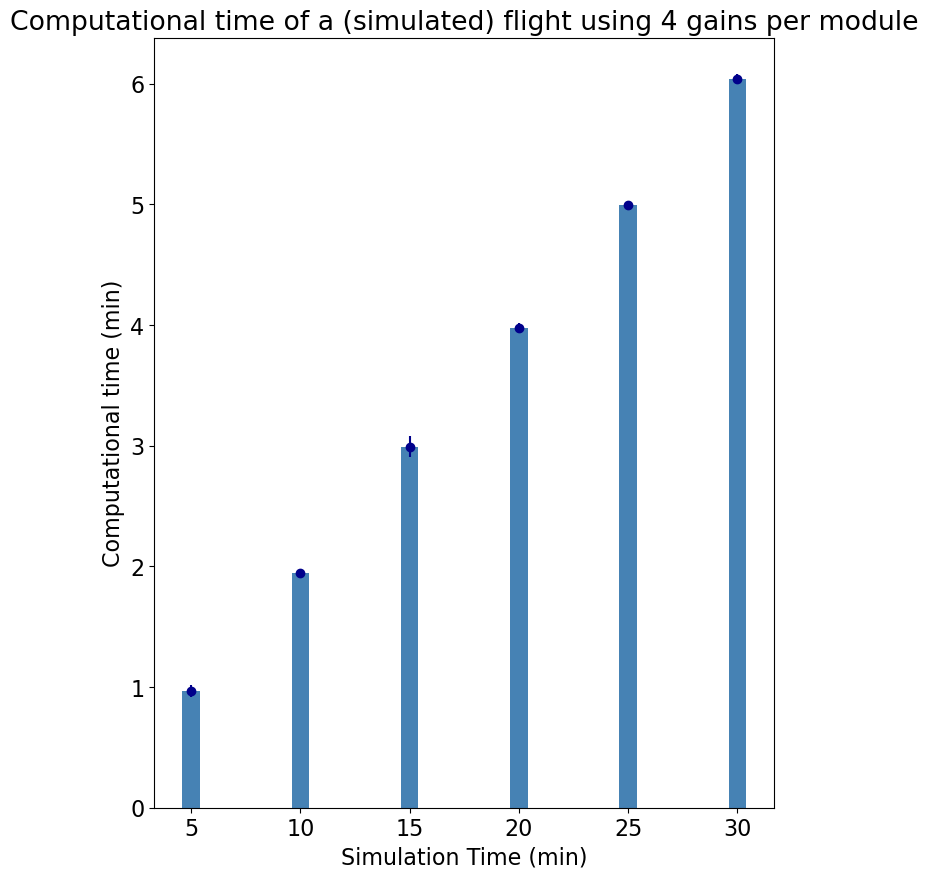

In [75]:
plt.rcParams.update({'font.size': 16})

x =  minutes
er = [std[:,0]/60, std[:,1]/60]
times_ = times/60
fig = plt.figure(figsize=(8,10))
plt.bar(x, times_, color="steelblue")
plt.errorbar(x, times_, er, fmt="o", color="darkblue")
plt.xticks(x)
plt.ylabel("Computational time (min)")
plt.xlabel("Simulation Time (min)")
plt.title("Computational time of a (simulated) flight using 4 gains per module")
#ig.savefig(f'Results\\PaperCompTime.pdf', format='pdf', bbox_inches='tight')
#fig.savefig(f'Results\\PaperCompTime.png', format='png', bbox_inches='tight')
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3,) and arg 1 with shape (6,).

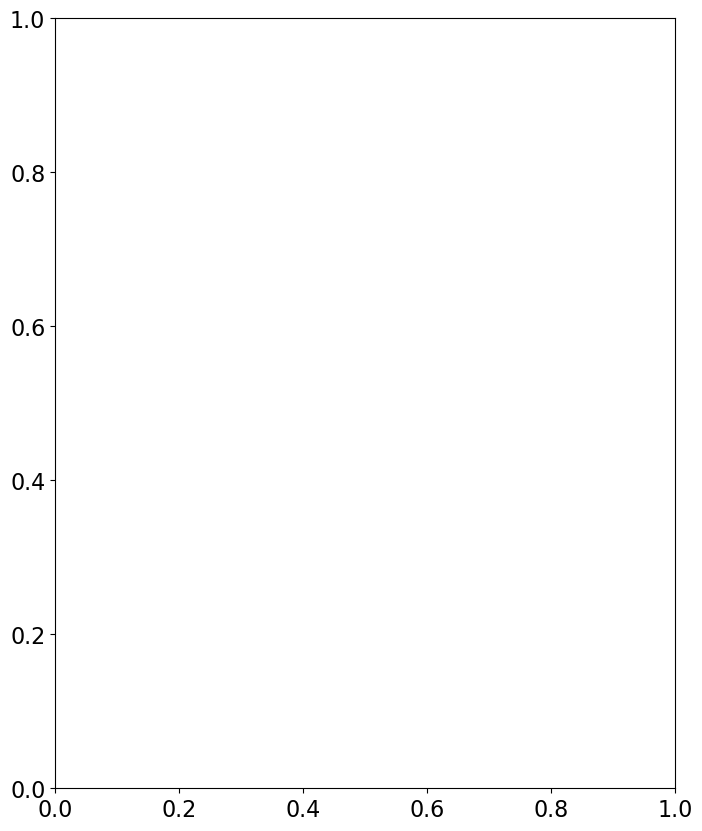

In [69]:
plt.rcParams.update({'font.size': 16})

x = [3, 4, 5] # amount of gains
er = [std[:,0]/60, std[:,1]/60]
times_ = times/60
fig = plt.figure(figsize=(8,10))
plt.bar(x, times_, color="steelblue")
plt.errorbar(x, times_, er, fmt="o", color="darkblue")
plt.xticks(x)
plt.ylabel("Computational time (min)")
plt.xlabel("Gains per Module")
plt.title("Computational time of a 10 minute (simulated) flight")
#ig.savefig(f'Results\\PaperCompTime.pdf', format='pdf', bbox_inches='tight')
#fig.savefig(f'Results\\PaperCompTime.png', format='png', bbox_inches='tight')
plt.show()

# Plot Activity and Trajectory

In [50]:
idx = 5
#name = f'computational and noise test Setting {1}of{3}'
name = f'Paper Noise variation Setting {idx}of{6}'
filename = f'Results\\ID {name}\\summary.pickle'
data = load_object(filename)

print(data.keys())
time_med = data['median time taken']
time_std = data['std time taken']
time_iqr = data['iqr time taken']
noise = data['setting var'][idx]
#gains = data['setting var']
#mse = [mse_on, mse_of, mse_onSh, mse_ofSh]
#std = [std_on, std_of, std_onSh, std_ofSh]
#per = [per_on, per_of, per_onSh, per_ofSh]
#labels = ['RLS 100', 'RR 100', 'RLS 80', 'RR 80']

filename = f'Results\\ID {name}\\data_trial0.pickle'
data = load_object(filename)

time = data['sim time']
activity = np.array(data['activity'])
pos_r = np.array(data['position'])
pos_rr_o = np.array(data['y_pred_rr overfit'])
pos_rls_o = np.array(data['y_pred_rls overfit'])
pos_rr_c = np.array(data['y_pred_rr non_overfit'])
pos_rls_c = np.array(data['y_pred_rls non_overfit'])

prj_op = np.array(data['module operators'])
projection = np.array(data['modular projections'])
gains = np.array(data['gains'])



pos_labels = ['Real', 'RR O', 'RLS O', 'RR C', 'RLS C']

dict_keys(['median y_pred_rr overfit', 'std y_pred_rr overfit', 'iqr y_pred_rr overfit', 'median mse_rr overfit', 'std mse_rr overfit', 'iqr mse_rr overfit', 'median r2_rr overfit', 'std r2_rr overfit', 'iqr r2_rr overfit', 'median y_pred_rls overfit', 'std y_pred_rls overfit', 'iqr y_pred_rls overfit', 'median mse_rls overfit', 'std mse_rls overfit', 'iqr mse_rls overfit', 'median r2_rls overfit', 'std r2_rls overfit', 'iqr r2_rls overfit', 'median y_pred_rr non_overfit', 'std y_pred_rr non_overfit', 'iqr y_pred_rr non_overfit', 'median mse_rr non_overfit', 'std mse_rr non_overfit', 'iqr mse_rr non_overfit', 'median r2_rr non_overfit', 'std r2_rr non_overfit', 'iqr r2_rr non_overfit', 'median y_pred_rls non_overfit', 'std y_pred_rls non_overfit', 'iqr y_pred_rls non_overfit', 'median mse_rls non_overfit', 'std mse_rls non_overfit', 'iqr mse_rls non_overfit', 'median r2_rls non_overfit', 'std r2_rls non_overfit', 'iqr r2_rls non_overfit', 'median volume', 'std volume', 'iqr volume', 'm

In [43]:
print(noise)

1.0


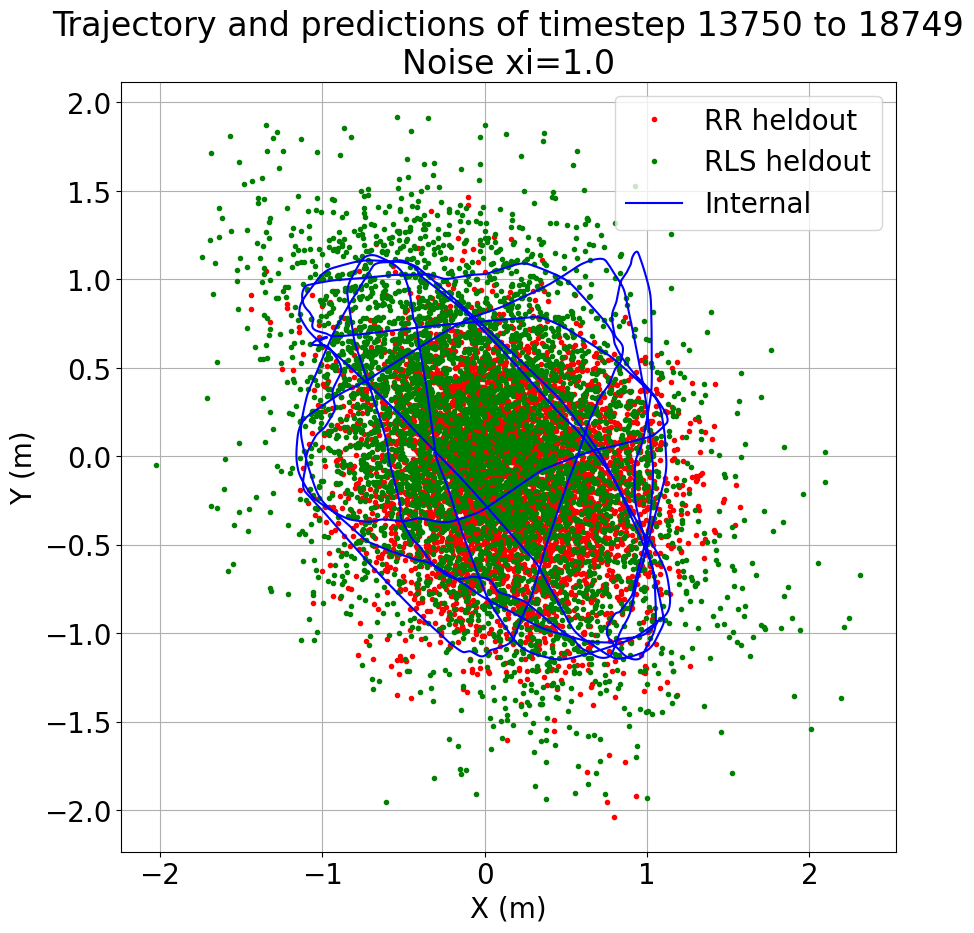

In [51]:

start = -5000
stop = -1
plt.title(f'Trajectory and predictions of timestep {start if start >= 0 else len(pos_r)-1+start} to {stop if stop > 0 else len(pos_r)-1+stop}\nNoise xi={noise}')
#plt.plot(pos_rr_o[start:stop,0], pos_rr_o[start:stop,1], 'r.', label = 'RR Overfit')
#plt.plot(pos_rls_o[start:stop,0], pos_rls_o[start:stop,1], 'g.', label = 'RLS Overfit')
plt.plot(pos_rr_c[start:stop,0], pos_rr_c[start:stop,1], 'r.', label = 'RR heldout')
plt.plot(pos_rls_c[start:stop,0], pos_rls_c[start:stop,1], 'g.', label = 'RLS heldout')
plt.plot(pos_r[start:stop,0], pos_r[start:stop,1], 'b-', label = 'Internal')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.grid()
plt.legend()
plt.savefig('Results\\PaperFigures\\TrajectoryCVHighNoise.png', format = 'png')
plt.show()

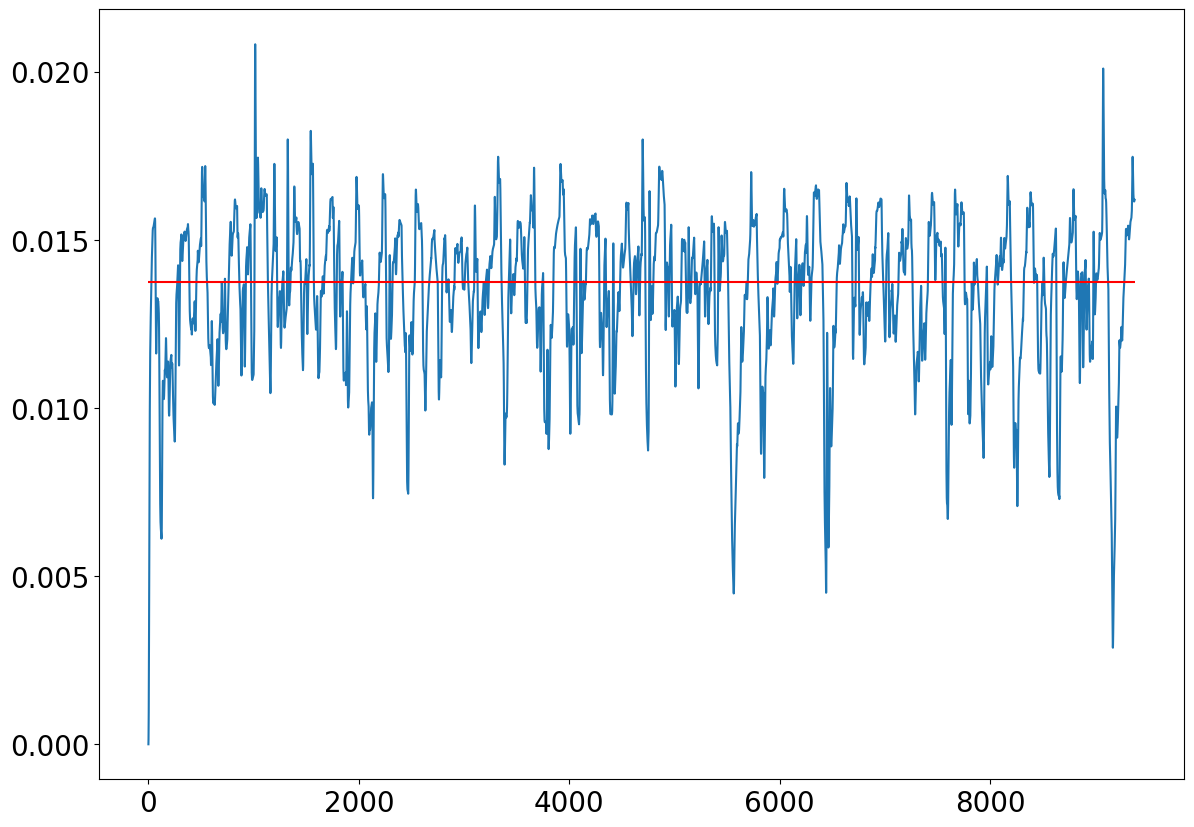

In [29]:
distance = np.linalg.norm(np.diff(pos_r, axis=0), axis=1)
plt.plot(distance)
plt.hlines(np.median(distance), 0, len(distance), color='red')

In [6]:
ntime, nmod, ngain, nneuron = np.shape(activity)
neurons = nmod*ngain*nneuron

Projection in ZX plane


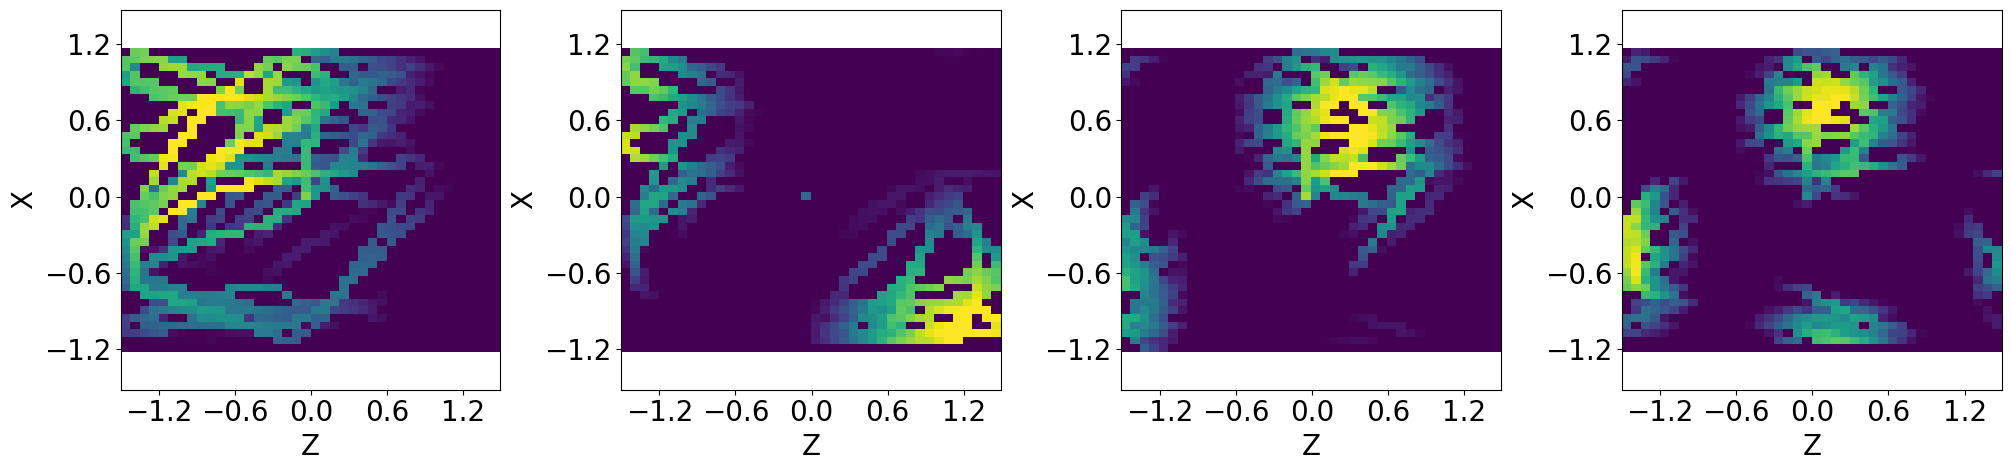

Projection in XY plane


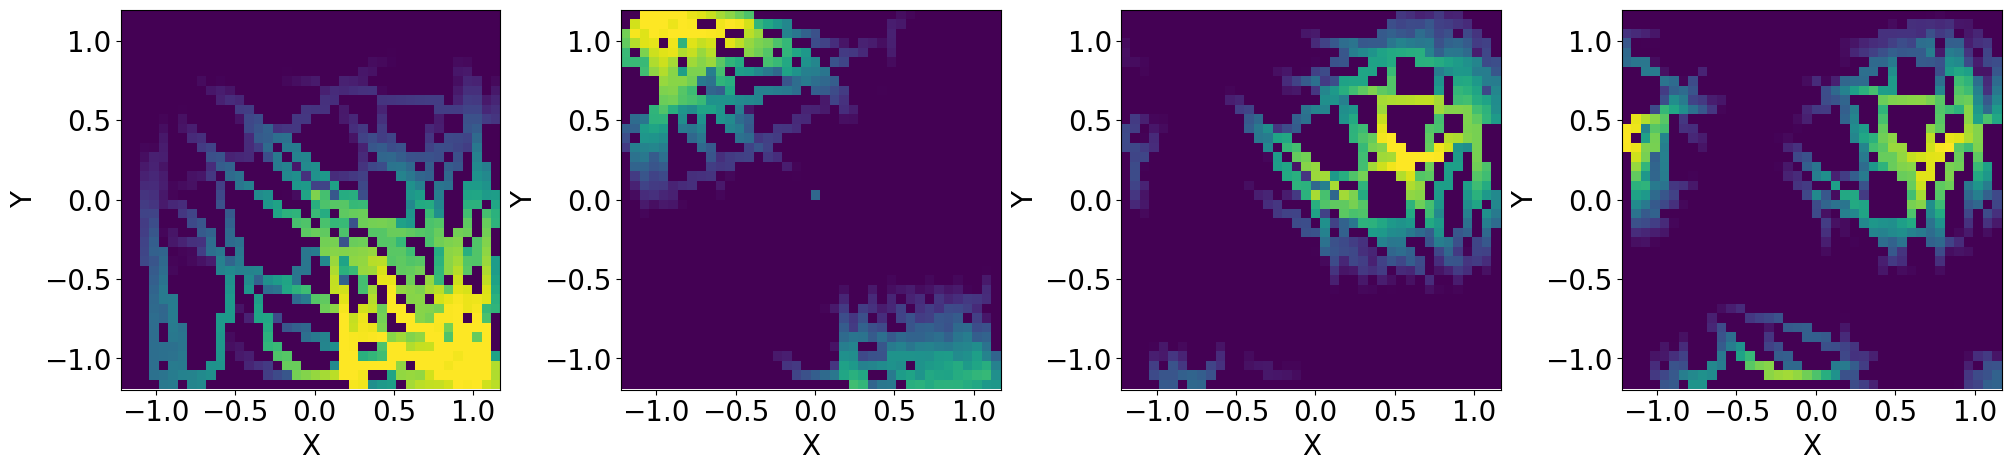

Projection in YZ plane


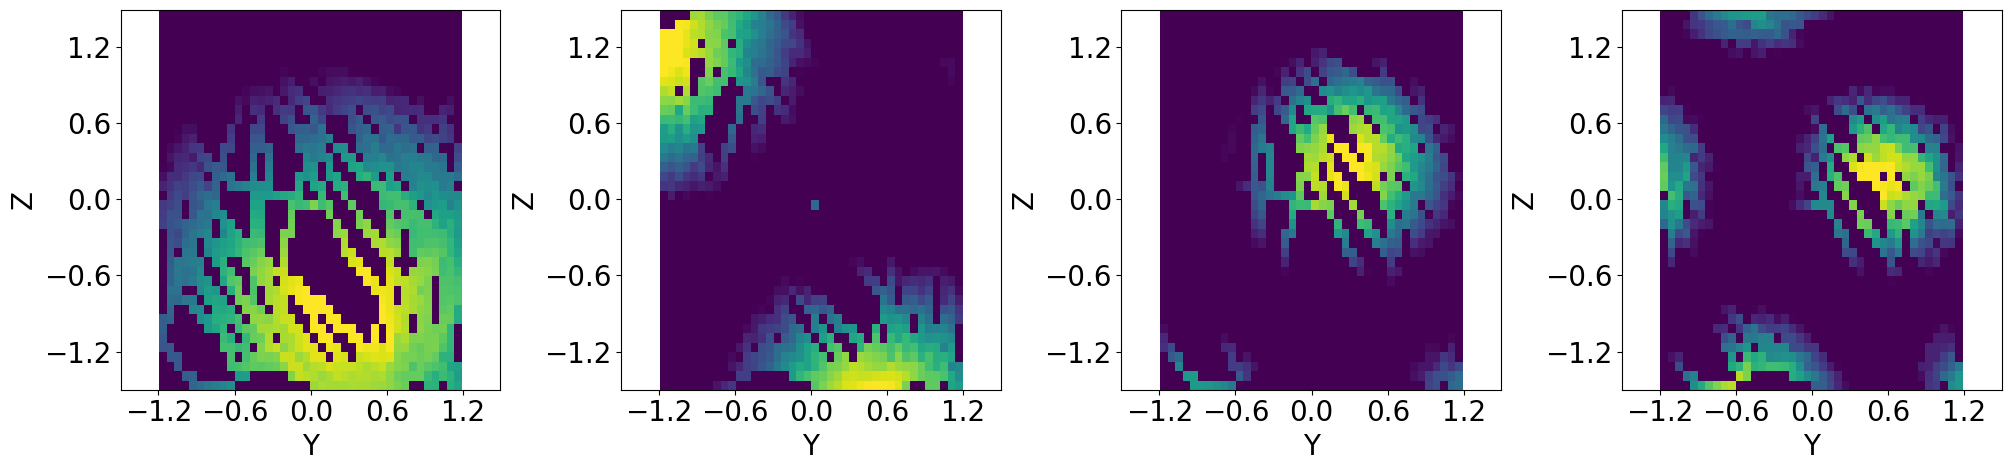

In [39]:
save_path = 'Results\\PaperFigures'
os.makedirs(save_path, exist_ok=True)
plot_modular_activity(prj_op, pos_r, activity, gains, projection, neuron=42, save=True, save_path=save_path, bins=40)
#for i in range(neurons):
#    print(i)
#    plot_modular_activity(prj_op, pos_r, activity, gains, projection, neuron=i, save=False, save_path=save_path, bins=40)

In [29]:
np.shape(prj_op), np.shape(pos_r), np.shape(activity), np.shape(gains), np.shape(projection)

((3, 2, 3), (9376, 3), (9376, 3, 4, 90), (4,), (3, 3))

In [37]:
def plot_modular_activity(prj_op, pos, ac, gains, projection, neuron=0, save=False, bins=20, save_path='Results'):
    pos2d = np.einsum('mnx, tx->mtn', prj_op, pos)
    abc = np.array(['X', 'Y', 'Z'] if projection.shape[0]==3 else ['X', 'Y'])
    
    # Define the order to get X, Y, Z on vertical axes from top to bottom
    # For each: (row_idx, swap_axes, plane_name, [h_label, v_label])
    plot_configs = [
        (2, True, 'ZX', ['Z', 'X']),   # Row 2: X-Z plane, swap to get Z horizontal, X vertical
        (0, False, 'XY', ['X', 'Y']),  # Row 0: X-Y plane, X horizontal, Y vertical
        (1, False, 'YZ', ['Y', 'Z'])   # Row 1: Y-Z plane, Y horizontal, Z vertical
    ]
    
    for row_idx, swap_axes, plane_name, dims_labels in plot_configs:
        print(f'Projection in {plane_name} plane')
        
        # Get the position data for this projection
        p = pos2d[row_idx]  # shape: (ntime, 2)
        
        # Swap columns if needed to get the correct axis arrangement
        if swap_axes:
            p = p[:, [1, 0]]  # Swap the two columns
        
        heatmap, x_edge, y_edge = get_heatmap(p, ac[:,row_idx], num_bins=bins, neuron=neuron)
        
        fig, ax = plot_heatmaps(
            heatmap, x_edge, y_edge, 
            gains=gains, 
            dimensions=dims_labels
        )
        
        if save:
            plt.savefig(f'{save_path}\\ActivityPlane{plane_name}neuron{neuron}.pdf', format='pdf')
            plt.savefig(f'{save_path}\\ActivityPlane{plane_name}neuron{neuron}.png', format='png')
        plt.show()
        
def get_heatmap(positions, activity, num_bins=50, neuron=0):
    """
    Generate a 3D heatmap of neural activity over XY space for different gain levels.

    Parameters
    ----------
    positions : array-like, shape = (ntime, 2)
        XY coordinates at each timepoint.
    activity : array-like, shape = (ntime, ngain, nneuron)
        Neural activity: time x gain levels x neurons.
    num_bins : int, optional (default=50)
        Number of bins along each spatial dimension.
    neuron : int, optional (default=42)
        Index of the neuron to plot.

    Returns
    -------
    heatmap : ndarray, shape = (ngain, num_bins, num_bins)
        Average activity of the specified neuron in each spatial bin for each gain.
        Bins with no samples are set to 0.
    x_edges : ndarray, shape = (num_bins + 1,)
        Bin edges along the X dimension.
    y_edges : ndarray, shape = (num_bins + 1,)
        Bin edges along the Y dimension.
    """
    positions = np.asarray(positions)
    activity = np.asarray(activity)

    # Validate dimensions
    ntime, dims = positions.shape
    t2, ngain, nneuron = activity.shape
    if t2 != ntime:
        raise ValueError(f"Time dimension mismatch: positions has {ntime}, activity has {t2}.")
    if neuron < 0 or neuron >= nneuron:
        raise ValueError(f"Neuron index out of bounds: should be in [0, {nneuron-1}].")

    # Define bin edges
    x_edges = np.linspace(positions[:, 0].min(), positions[:, 0].max(), num_bins + 1)
    y_edges = np.linspace(positions[:, 1].min(), positions[:, 1].max(), num_bins + 1)

    # Initialize accumulators
    sum_map = np.zeros((ngain, num_bins, num_bins), dtype=float)
    count_map = np.zeros((ngain, num_bins, num_bins), dtype=int)

    # Bin each sample
    for (x, y), act in zip(positions, activity):
        x_idx = np.clip(np.digitize(x, x_edges) - 1, 0, num_bins - 1)
        y_idx = np.clip(np.digitize(y, y_edges) - 1, 0, num_bins - 1)
        for g in range(ngain):
            sum_map[g, x_idx, y_idx] = max(act[g, neuron], sum_map[g, x_idx, y_idx])
            count_map[g, x_idx, y_idx] += 1

    # Compute average, set empty bins to 0
    heatmap = np.zeros_like(sum_map)
    nonzero = count_map > 0
    heatmap[nonzero] = sum_map[nonzero] #/ count_map[nonzero]
    # bins with no data remain 0

    return heatmap, x_edges, y_edges

def plot_heatmaps(heatmap, x_edges, y_edges, gains=None, cmap='viridis', dimensions=['X', 'Y']):
    """
    Plot one heatmap per gain level with equal aspect ratio and consistent ticks.
    """
    ngain, nbins, _ = heatmap.shape
    if gains is None:
        gains = np.arange(ngain)
    elif len(gains) != ngain:
        raise ValueError(f"Length of gains ({len(gains)}) must match heatmap dimension ({ngain}).")

    # Calculate the data ranges
    x_range = x_edges[-1] - x_edges[0]
    y_range = y_edges[-1] - y_edges[0]
    max_range = max(x_range, y_range)
    
    # Center both axes
    x_center = (x_edges[0] + x_edges[-1]) / 2
    y_center = (y_edges[0] + y_edges[-1]) / 2
    
    # Create equal limits
    equal_half_range = max_range / 2
    x_lim = [x_center - equal_half_range, x_center + equal_half_range]
    y_lim = [y_center - equal_half_range, y_center + equal_half_range]
    
    # Create square subplots
    fig, axes = plt.subplots(1, ngain, figsize=(5 * ngain, 5), constrained_layout=True)
    if ngain == 1:
        axes = [axes]

    vmin = np.min(heatmap)
    vmax = np.max(heatmap)

    for idx, ax in enumerate(axes):
        im = ax.imshow(
            heatmap[idx].T,
            origin='lower',
            extent=(x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]),
            aspect='auto',  # Use auto, we'll control with limits
            vmin=vmin,
            vmax=vmax,
            cmap=cmap
        )
        
        # Set equal limits for square display
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        
        # Force equal aspect ratio
        ax.set_aspect('equal', adjustable='box')
        
        # Set consistent tick formatting
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        
        ax.set_xlabel(dimensions[0])
        ax.set_ylabel(dimensions[1])

    return fig, axes

# Plot the results

In [ ]:
XYZoverTime(pos_i, pos_p, y_pred, [ 'position integrator', 'online prediction', 'offline prediction'], ['b-', 'r:', 'g:'])

In [ ]:
x, y, z = pos_r[:,0], pos_r[:,1], pos_r[:,2]
plt.plot(x, y, 'b:', label='xy path')
plt.plot(y, z, 'g:', label='yz path')
plt.plot(x, z, 'm:', label='xz path')
plt.grid()
plt.legend()
plt.show()

In [ ]:
plot_3d_trajectory(pos_r, boundaries, ID=ID)

In [ ]:
plot_prediction_path_3d(pos_r, pos_i, pos_r, np.mean(mse_ar), ID=ID)
prediction_path_projected(pos_i, pos_p, mse_ar, ID=ID)
plot_modular_activity(projection_operator, pos_i, activity, gains, ID, projection)